In [59]:
#Import Libraries

#!pip install --upgrade scikit-learn
#!pip install -U imbalanced-learn
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, OneHotEncoder, OrdinalEncoder
from imblearn.over_sampling import SMOTE

from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV
from sklearn.linear_model import Lasso, LassoCV
from sklearn.linear_model import ElasticNet, ElasticNetCV
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import accuracy_score, classification_report, plot_confusion_matrix, confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score

sns.set_context(context='talk')
sns.set_style('white')
%config InlineBackend.figure_format = 'retina'

%matplotlib inline

## Trap Data

In [60]:
df_trap = pd.read_csv('assets/train.csv')

#Convert date into datetime object for further comparison and filtering
df_trap['Date'] = pd.to_datetime(df_trap['Date'])

#Drop Address, Block, Street, AddressNumberAndStreet, sine we've already got the geographical coordinates
df_trap = df_trap.drop(columns=['Address','Block','Street','AddressNumberAndStreet'])

df_trap.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
1 2007-05-29          CULEX RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29          CULEX RESTUANS  T007  41.994991 -87.769279   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
4 2007-05-29          CULEX RESTUANS  T015  41.974089 -87.824812   

   AddressAccuracy  NumMosquitos  WnvPresent  
0                9             1           0  
1                9             1           0  
2                9             1           0  
3                8             1           0  
4                8             4           0

### Deciding which weather station will be used for each trap

Weather information at the nearest station will be used for each observation, therefore, we need to calculate the distance from each weather station with following information

- Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
- Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

For distance calculation, we'll use the empirical estimation of 1° = 111 km  (or 60 nautical miles)

In [61]:
# Distance calculation 1° = 111 km  (or 60 nautical miles)
lat_s1 = 41.995
long_s1 = -87.933
lat_s2 = 41.786
long_s2 = -87.752

df_trap['Distance_from_s1_km'] = np.sqrt(np.power(60*(df_trap['Latitude']- lat_s1),2)+
                                         np.power(60*(df_trap['Longitude']- long_s1),2))* 111/60 #*111/60 to convert from NM to km

df_trap['Distance_from_s2_km'] = np.sqrt(np.power(60*(df_trap['Latitude']- lat_s2),2)+
                                         np.power(60*(df_trap['Longitude']- long_s2),2))* 111/60 #*111/60 to convert from NM to km

#Select dominant weather station
df_trap['Station'] =df_trap.apply(lambda row: 2 if (row['Distance_from_s1_km'] > row['Distance_from_s2_km']) else 1 , axis = 1)

In [62]:
df_trap.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
1 2007-05-29          CULEX RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29          CULEX RESTUANS  T007  41.994991 -87.769279   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
4 2007-05-29          CULEX RESTUANS  T015  41.974089 -87.824812   

   AddressAccuracy  NumMosquitos  WnvPresent  Distance_from_s1_km  \
0                9             1           0            15.320924   
1                9             1           0            15.320924   
2                9             1           0            18.173031   
3                8             1           0            12.231129   
4                8             4           0            12.231129   

   Distance_from_s2_km  Station  
0            19.498260        1  
1            19.498260        1  
2            23.277153        1  
3            22.387646        1  
4            22.387646        1

## Weather Data

- Station 1: CHICAGO O'HARE INTERNATIONAL AIRPORT Lat: 41.995 Lon: -87.933 Elev: 662 ft. above sea level
- Station 2: CHICAGO MIDWAY INTL ARPT Lat: 41.786 Lon: -87.752 Elev: 612 ft. above sea level

In [63]:
df_weather = pd.read_csv('assets/weather.csv')

#Convert Date into Datetime object
df_weather['Date'] = pd.to_datetime(df_weather['Date'])

#Convert Data types to one that suitable for our analysis
df_weather['PrecipTotal'] = df_weather['PrecipTotal'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['WetBulb'] = df_weather['WetBulb'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['Heat'] = df_weather['Heat'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['Cool'] = df_weather['Cool'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['StnPressure'] = df_weather['StnPressure'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['SeaLevel'] = df_weather['SeaLevel'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['Tavg'] = df_weather['Tavg'].map(lambda s: -1 if s.strip().isalpha() else float(s))
df_weather['Depart'] = df_weather['Depart'].map(lambda s: 0 if s.strip().isalpha() else float(s))

#Feature engineering
df_weather['%RH'] = 100 - (25/9)*(df_weather['Tavg'] - df_weather['DewPoint'])
df_weather['Tdiff'] = df_weather['Tmax'] - df_weather['Tmin']


#Divide weather data into 2 dataframe according to weather station

weather_1 = df_weather[df_weather['Station'] == 1].set_index('Date')
weather_2 = df_weather[df_weather['Station'] == 2].set_index('Date')


### Feature Engineering on Station 1 data

Motivation: [Mosquito life cycle](https://www.cdc.gov/dengue/resources/factsheets/mosquitolifecyclefinal.pdf)
- The entire life cycle, from an egg to an adult, takes approximately 8-10 days.
- Female mosquitoes lay eggs inside containers holding water.



In [64]:
#Count the number of days since the last rain,
days_since_last_rain = []
count = 0
for rain in weather_1['PrecipTotal'] :
    if rain <= 0:
        count += 1
        days_since_last_rain.append(count)
    if rain > 0:
        count = 0
        days_since_last_rain.append(count)
        
days_since_last_rain = pd.Series(days_since_last_rain,index=weather_1.index,name='days_since_last_rain')

In [65]:
#10 days lagged with Exponential Weighted Mean smoothening
d10ewm_Tavg = weather_1.Tavg.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tavg')
d10ewm_Tdiff = weather_1.Tdiff.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tdiff')
d10ewm_Tmax = weather_1.Tmax.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tmax')
d10ewm_Tmin = weather_1.Tmin.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tmin')
d10ewm_RH = weather_1['%RH'].shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_RH')

#Combine engineered features into the original dataframe
weather_1 = pd.concat([weather_1,
                       d10ewm_Tavg,
                       d10ewm_Tdiff,
                       d10ewm_Tmax,
                       d10ewm_Tmin,
                       d10ewm_RH,
                       days_since_last_rain]
                      ,axis=1)
weather_1 = weather_1.dropna(subset=['Station'])
weather_1['10ewm_Tavg'] = weather_1['10ewm_Tavg'].fillna(weather_1['Tavg'])
weather_1['10ewm_Tdiff'] = weather_1['10ewm_Tdiff'].fillna(weather_1['Tdiff'])
weather_1['10ewm_Tmax'] = weather_1['10ewm_Tmax'].fillna(weather_1['Tmax'])
weather_1['10ewm_Tmin'] = weather_1['10ewm_Tmin'].fillna(weather_1['Tmin'])
weather_1['10ewm_RH'] = weather_1['10ewm_RH'].fillna(weather_1['%RH'])

The raw %RH itselt can't simply be a good predictor. Therefore, we decide to binning it and observe the result.

In [66]:
#Binning 10erw_rh
def bin_rh(row):
    if row < 50:
        return 1
    elif row < 60:
        return 2
    elif row < 70:
        return 3
    else:
        return 4
weather_1['10ewm_RH_bin'] = weather_1['10ewm_RH'].map(bin_rh)

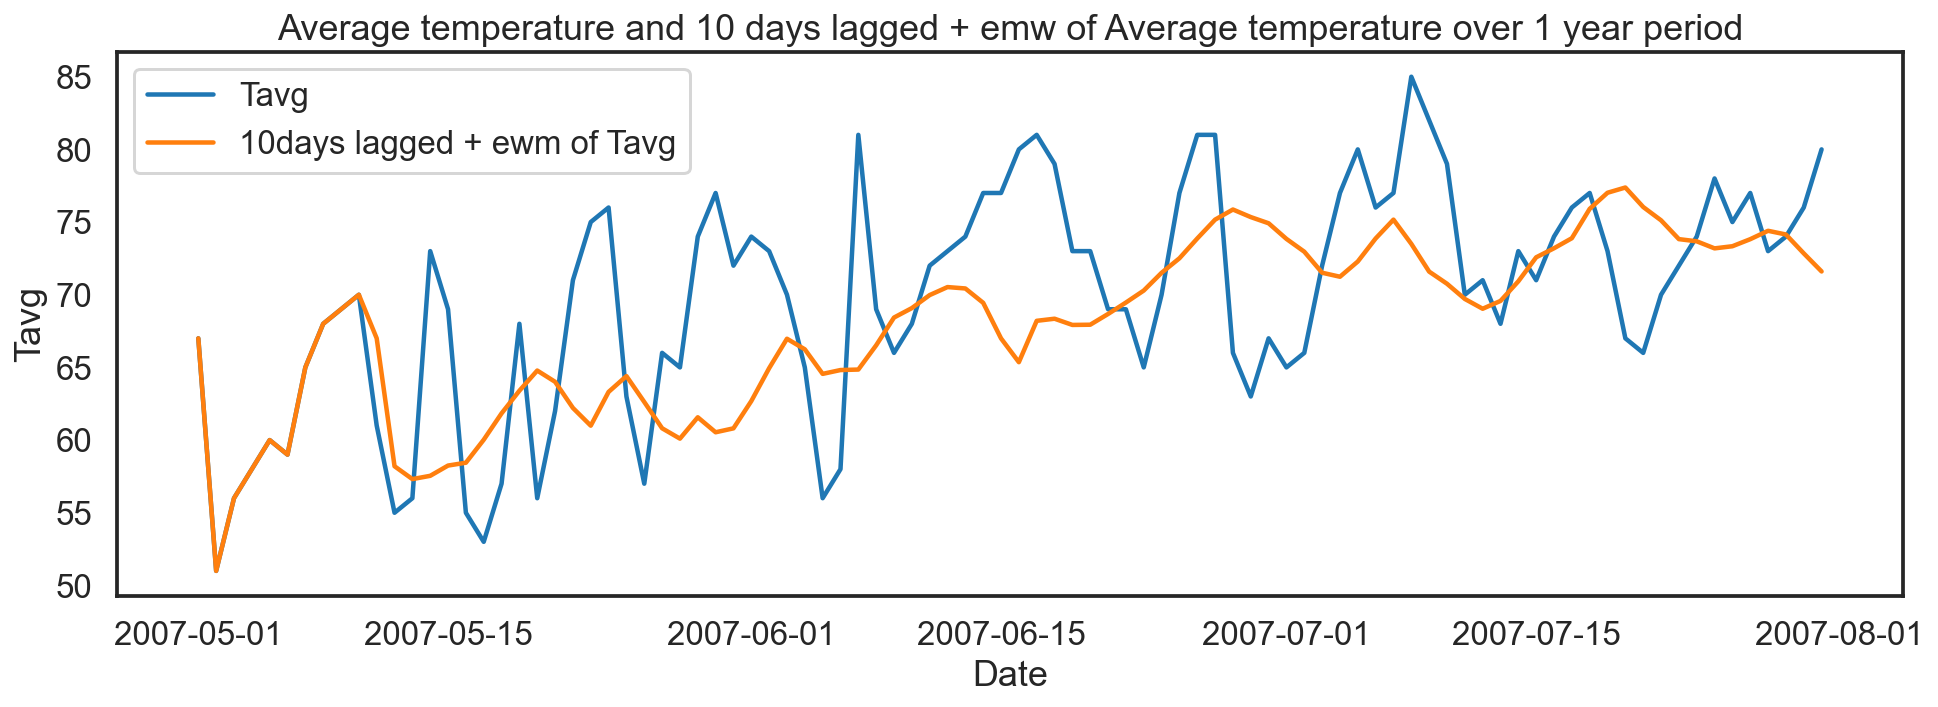

In [67]:
#@title Default title text
plt.figure(figsize=(16,5))
g = sns.lineplot(data=weather_1[(weather_1.index.year == 2007) & (weather_1.index.month < 8 )], x = 'Date', y='Tavg')
g = sns.lineplot(data=weather_1[(weather_1.index.year == 2007) & (weather_1.index.month < 8)], x = 'Date', y='10ewm_Tavg')
plt.legend(['Tavg','10days lagged + ewm of Tavg'])
plt.title('Average temperature and 10 days lagged + emw of Average temperature over 1 year period');

### Feature Engineering on Station 2 data

we employ the same feature engineering process on weather data of station 2.

In [68]:
#Count the number of days since the last rain,
days_since_last_rain = []
count = 0
for rain in weather_2['PrecipTotal'] :
    if rain <= 0:
        count += 1
        days_since_last_rain.append(count)
    if rain > 0:
        count = 0
        days_since_last_rain.append(count)
        
days_since_last_rain = pd.Series(days_since_last_rain,index=weather_2.index,name='days_since_last_rain')

In [69]:
#10 days lagged with Exponential Weighted Mean smoothening
d10ewm_Tavg = weather_2.Tavg.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tavg')
d10ewm_Tdiff = weather_2.Tdiff.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tdiff')
d10ewm_Tmax = weather_2.Tmax.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tmax')
d10ewm_Tmin = weather_2.Tmin.shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_Tmin')
d10ewm_RH = weather_2['%RH'].shift(10).resample('D').mean().ewm(span=10).mean().rename('10ewm_RH')

#Combine engineered features into the original dataframe
weather_2 = pd.concat([weather_2,
                       d10ewm_Tavg,
                       d10ewm_Tdiff,
                       d10ewm_Tmax,
                       d10ewm_Tmin,
                       d10ewm_RH,
                       days_since_last_rain]
                      ,axis=1)
weather_2 = weather_2.dropna(subset=['Station'])
weather_2['10ewm_Tavg'] = weather_2['10ewm_Tavg'].fillna(weather_2['Tavg'])
weather_2['10ewm_Tdiff'] = weather_2['10ewm_Tdiff'].fillna(weather_2['Tdiff'])
weather_2['10ewm_Tmax'] = weather_2['10ewm_Tmax'].fillna(weather_2['Tmax'])
weather_2['10ewm_Tmin'] = weather_2['10ewm_Tmin'].fillna(weather_2['Tmin'])
weather_2['10ewm_RH'] = weather_2['10ewm_RH'].fillna(weather_2['%RH'])
weather_2['10ewm_RH_bin'] = weather_2['10ewm_RH'].map(bin_rh)

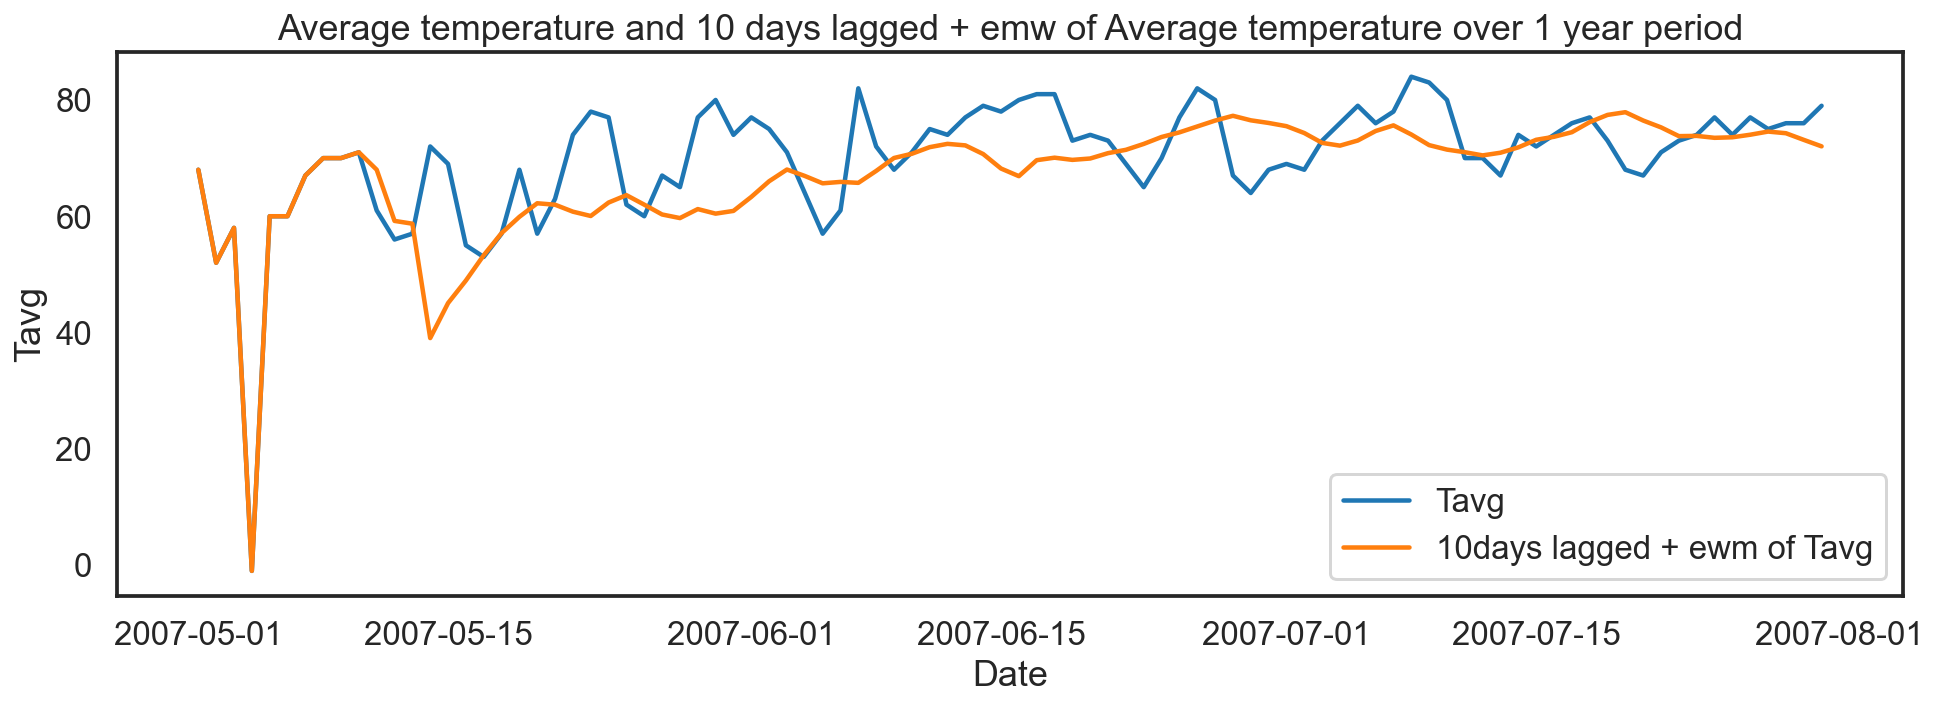

In [70]:
#@title Default title text { display-mode: "code" }
plt.figure(figsize=(16,5))
g = sns.lineplot(data=weather_2[(weather_2.index.year == 2007) & (weather_2.index.month < 8 )], x = 'Date', y='Tavg')
g = sns.lineplot(data=weather_2[(weather_2.index.year == 2007) & (weather_2.index.month < 8)], x = 'Date', y='10ewm_Tavg')
plt.legend(['Tavg','10days lagged + ewm of Tavg'])
plt.title('Average temperature and 10 days lagged + emw of Average temperature over 1 year period');

In [71]:
df_weather = pd.concat([weather_1,weather_2]).sort_index()

## Merged Trap and Weather data into single dataframe

In [72]:
#Merging related weather information to the trap dataframe
df_merged = pd.merge(df_trap,df_weather,left_on=['Date','Station'],right_on=['Date','Station'])

#Extract Year and Month to separated features to see if there is any temporal relationship
df_merged['Year'] = df_merged['Date'].dt.year
df_merged['Month'] = df_merged['Date'].dt.month

df_merged.head()

Date                 Species  Trap   Latitude  Longitude  \
0 2007-05-29  CULEX PIPIENS/RESTUANS  T002  41.954690 -87.800991   
1 2007-05-29          CULEX RESTUANS  T002  41.954690 -87.800991   
2 2007-05-29          CULEX RESTUANS  T007  41.994991 -87.769279   
3 2007-05-29  CULEX PIPIENS/RESTUANS  T015  41.974089 -87.824812   
4 2007-05-29          CULEX RESTUANS  T015  41.974089 -87.824812   

   AddressAccuracy  NumMosquitos  WnvPresent  Distance_from_s1_km  \
0                9             1           0            15.320924   
1                9             1           0            15.320924   
2                9             1           0            18.173031   
3                8             1           0            12.231129   
4                8             4           0            12.231129   

   Distance_from_s2_km  ...  Tdiff  10ewm_Tavg  10ewm_Tdiff  10ewm_Tmax  \
0            19.498260  ...   28.0   61.568361    24.105318   73.399798   
1            19.498260  ...   28.0   61.568361    24.105318   73.399798   
2            23.277153  ...   28.0   61.568361    24.105318   73.399798   
3            22.387646  ...   28.0   61.568361    24.105318   73.399798   
4            22.387646  ...   28.0   61.568361    24.105318   73.399798   

   10ewm_Tmin   10ewm_RH  days_since_last_rain  10ewm_RH_bin  Year Month  
0    49.29448  40.249808                   2.0             1  2007     5  
1    49.29448  40.249808                   2.0             1  2007     5  
2    49.29448  40.249808                   2.0             1  2007     5  
3    49.29448  40.249808                   2.0             1  2007     5  
4    49.29448  40.249808                   2.0             1  2007     5  

[5 rows x 42 columns]

In [73]:
df_merged.shape

(10506, 42)

## Exploratory Data Analysis (EDA)

It is believed that hot and dry conditions are more favorable for West Nile virus than cold and wet.

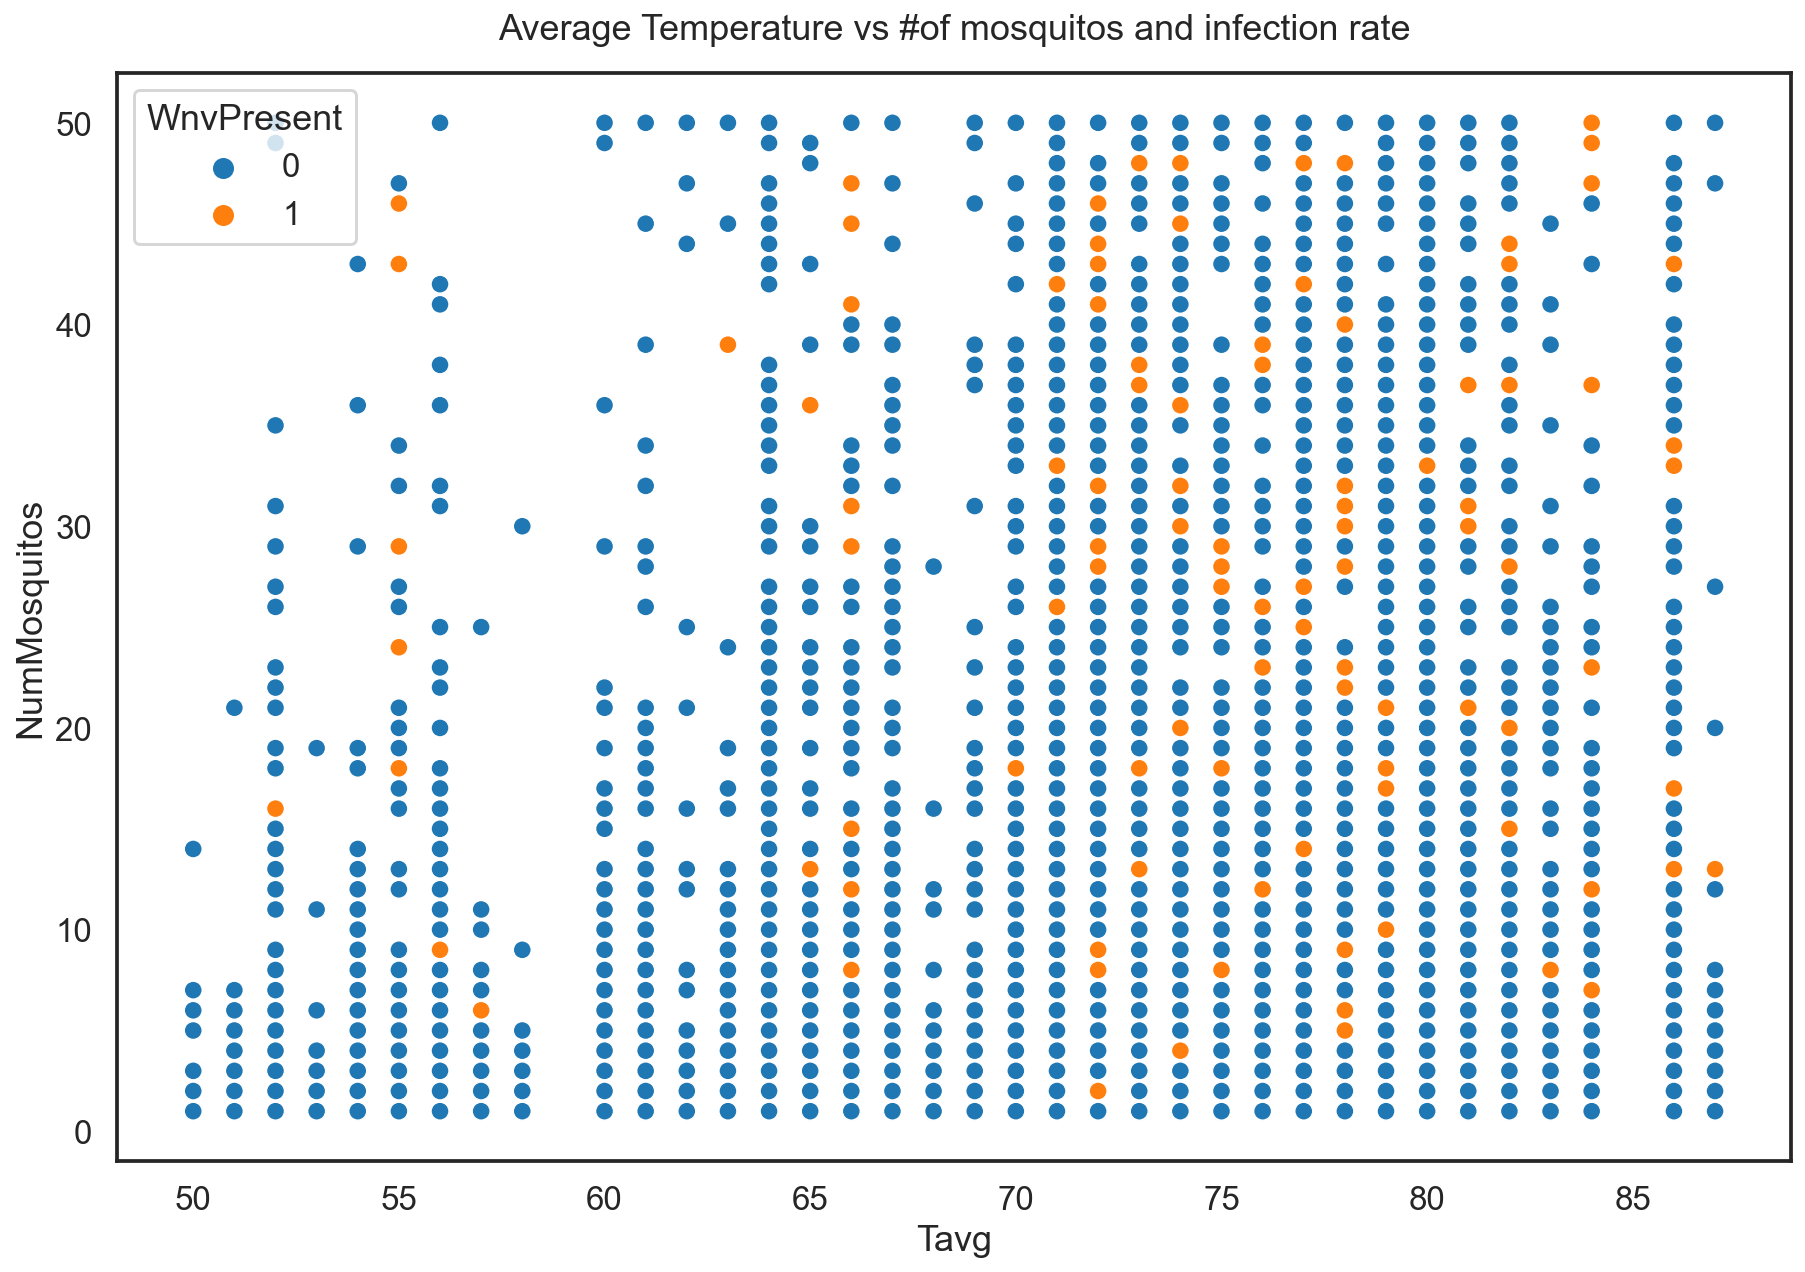

In [74]:
plt.figure(figsize=(15,10))
sns.scatterplot(data=df_merged.sort_values(by='Tavg'), x = 'Tavg', y = 'NumMosquitos',hue = 'WnvPresent');
plt.title('Average Temperature vs #of mosquitos and infection rate',y=1.02);

It's obvious that the higher temperature leads to higher infection rate. A threshold at 72 Farenheit clearly separted low and high WNv spread.

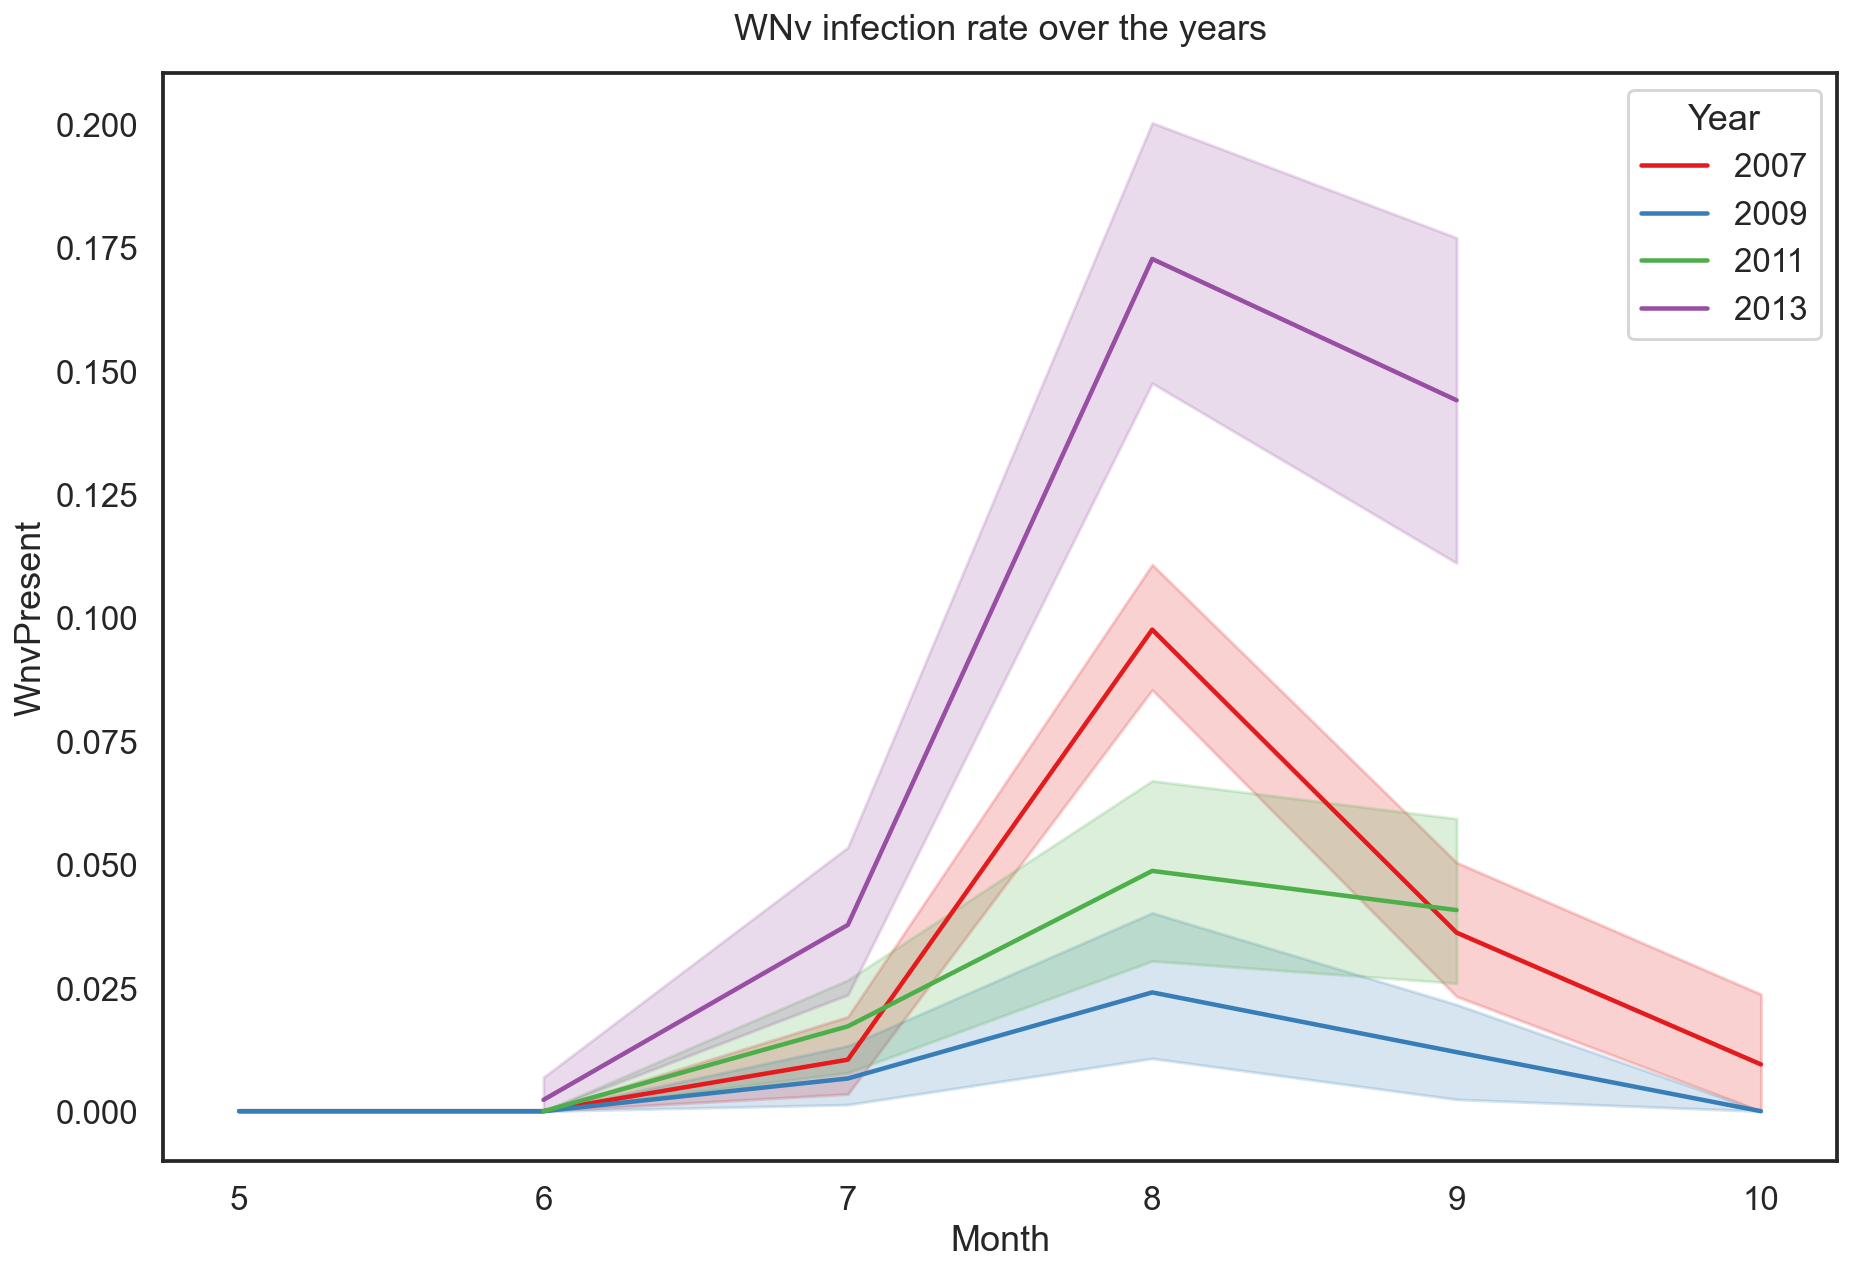

In [75]:
plt.figure(figsize=(15,10))
sns.lineplot(data=df_merged, x = 'Month',y = 'WnvPresent', hue = 'Year',palette='Set1' )
plt.title('WNv infection rate over the years',y=1.02);

The WNv spread heavily during August of every years.

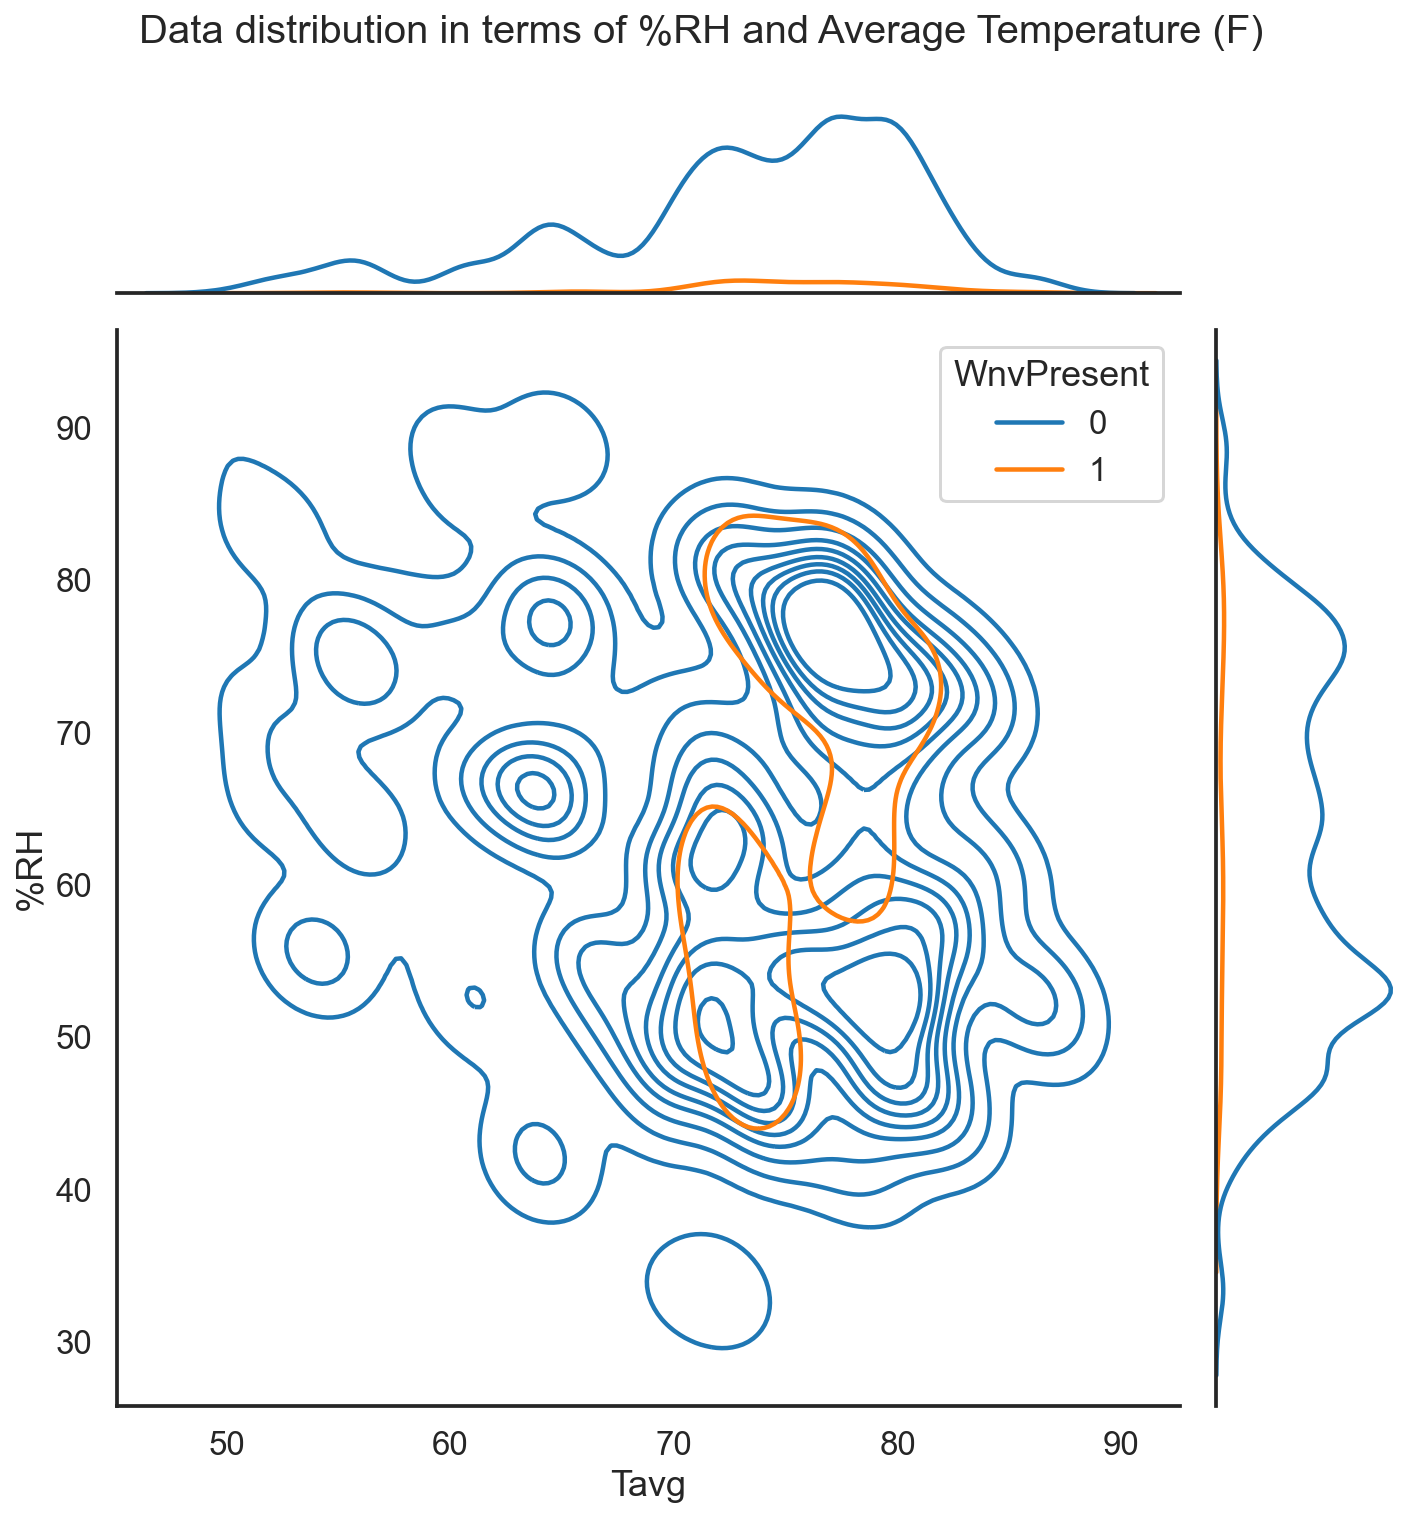

In [76]:
# Calculating Relative Humidity (%RH)
g = sns.jointplot(data=df_merged, x="Tavg", y="%RH", hue='WnvPresent', kind = 'kde', height = 10);
g.fig.suptitle('Data distribution in terms of %RH and Average Temperature (F)',y = 1.05, fontsize = 20);

- It's clear that the WNv can spread easily in optimal range of temperature (between 70-80 degFarenheit)
- In term of relative humidity, the virus is likely to spread widely in relatively humid environment (%RH from 50% - 80%)

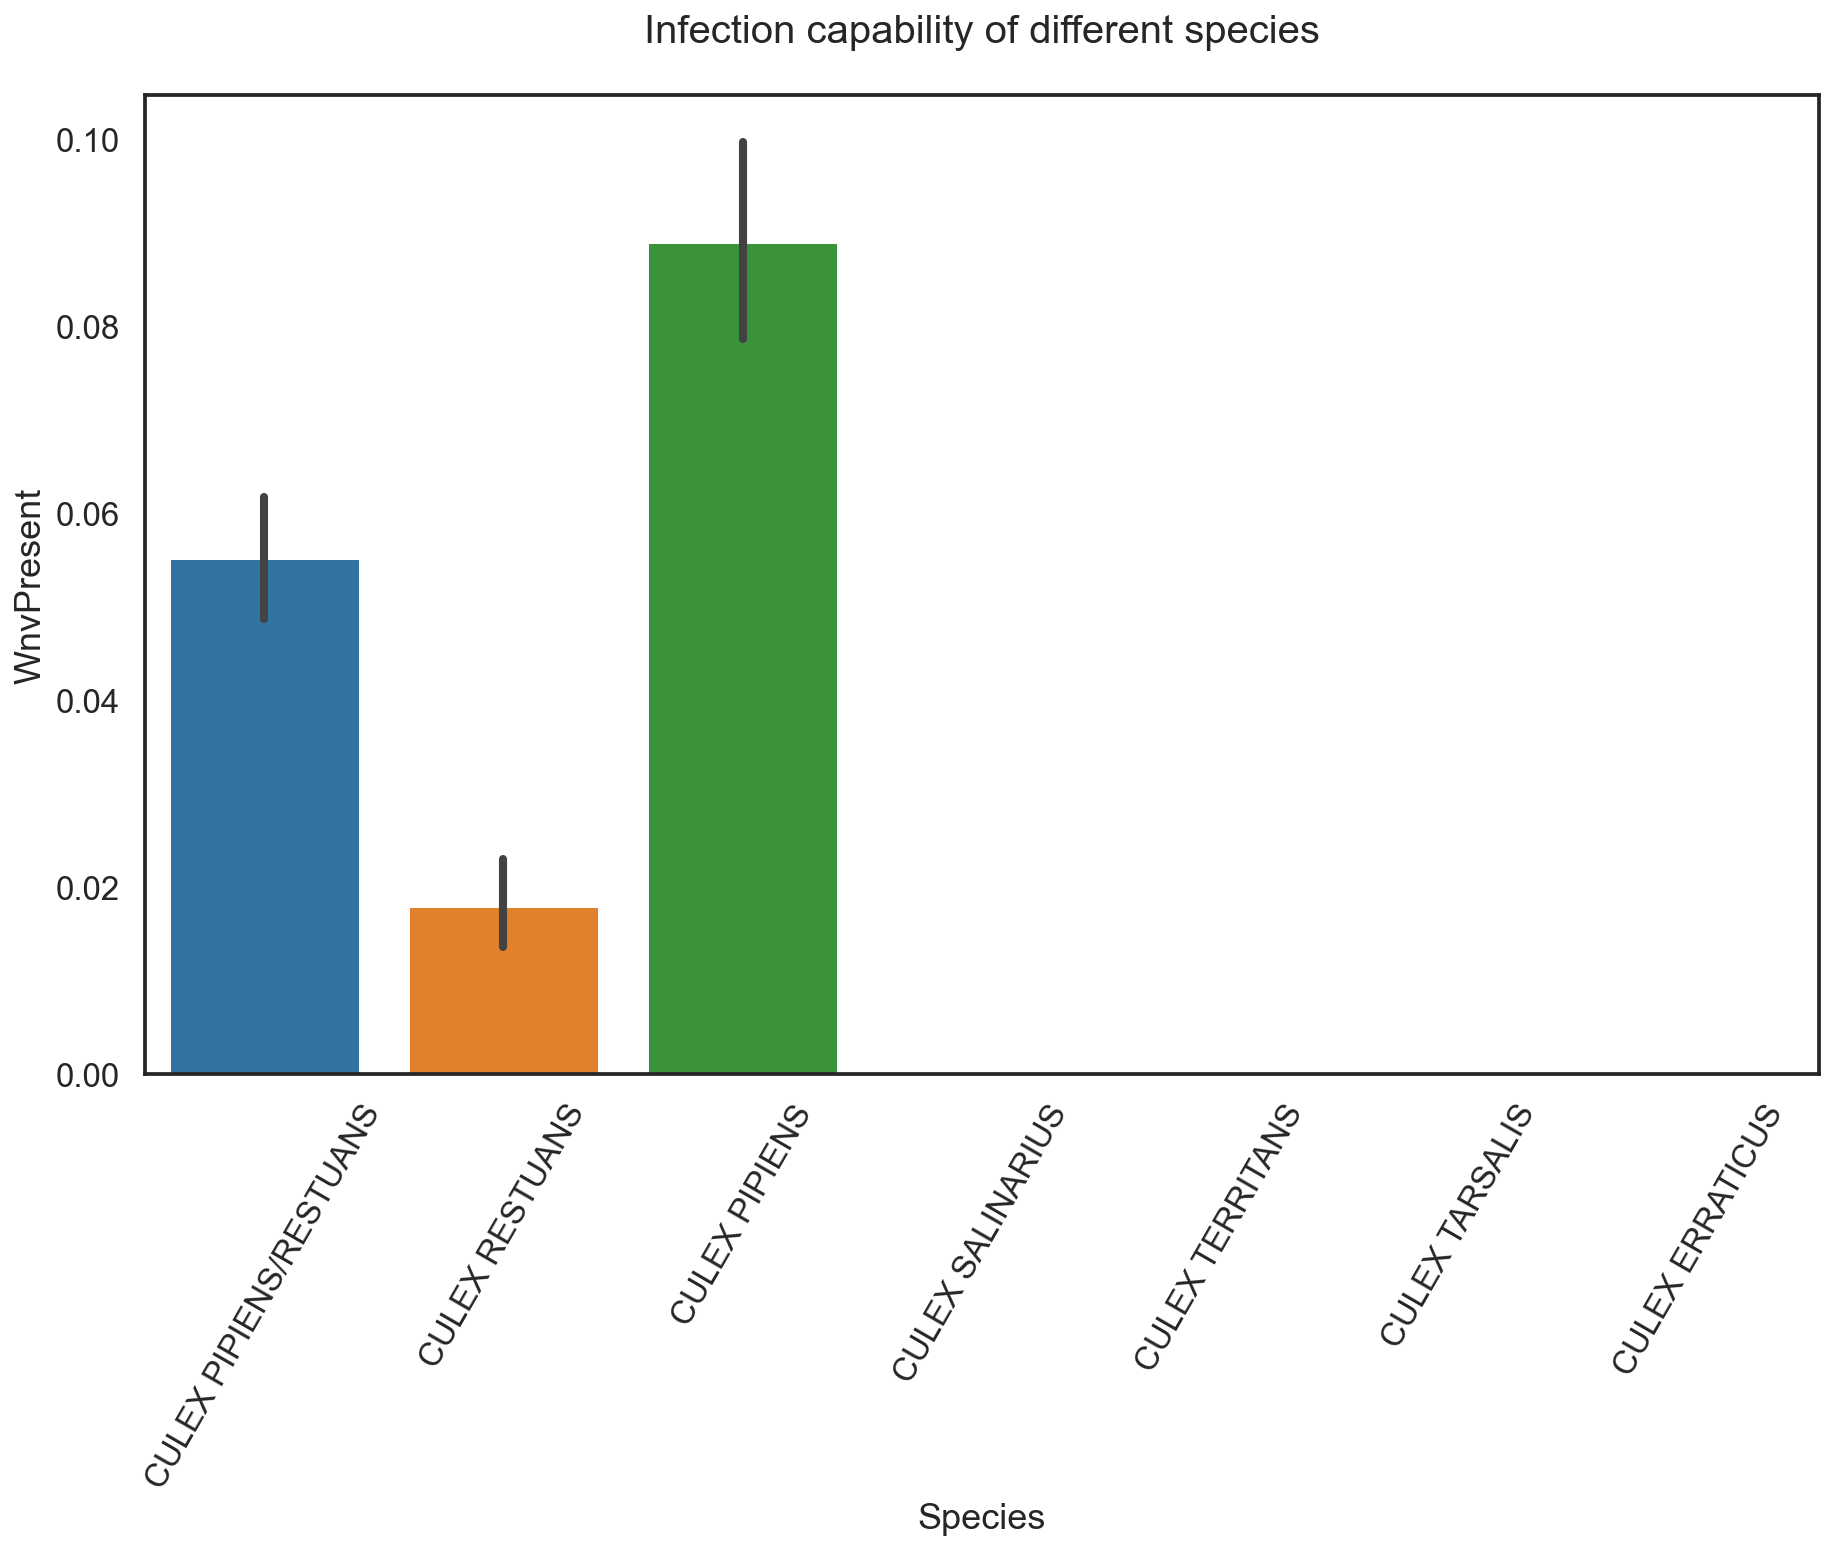

In [77]:
plt.figure(figsize=(15,9))
g = sns.barplot(x='Species',y='WnvPresent',data=df_merged)
g.set_xticklabels(g.get_xticklabels(),rotation = 60)
plt.title('Infection capability of different species\n', fontsize=20);

Three species are the carrier of WNv, the rest have no presence of WNv infection.

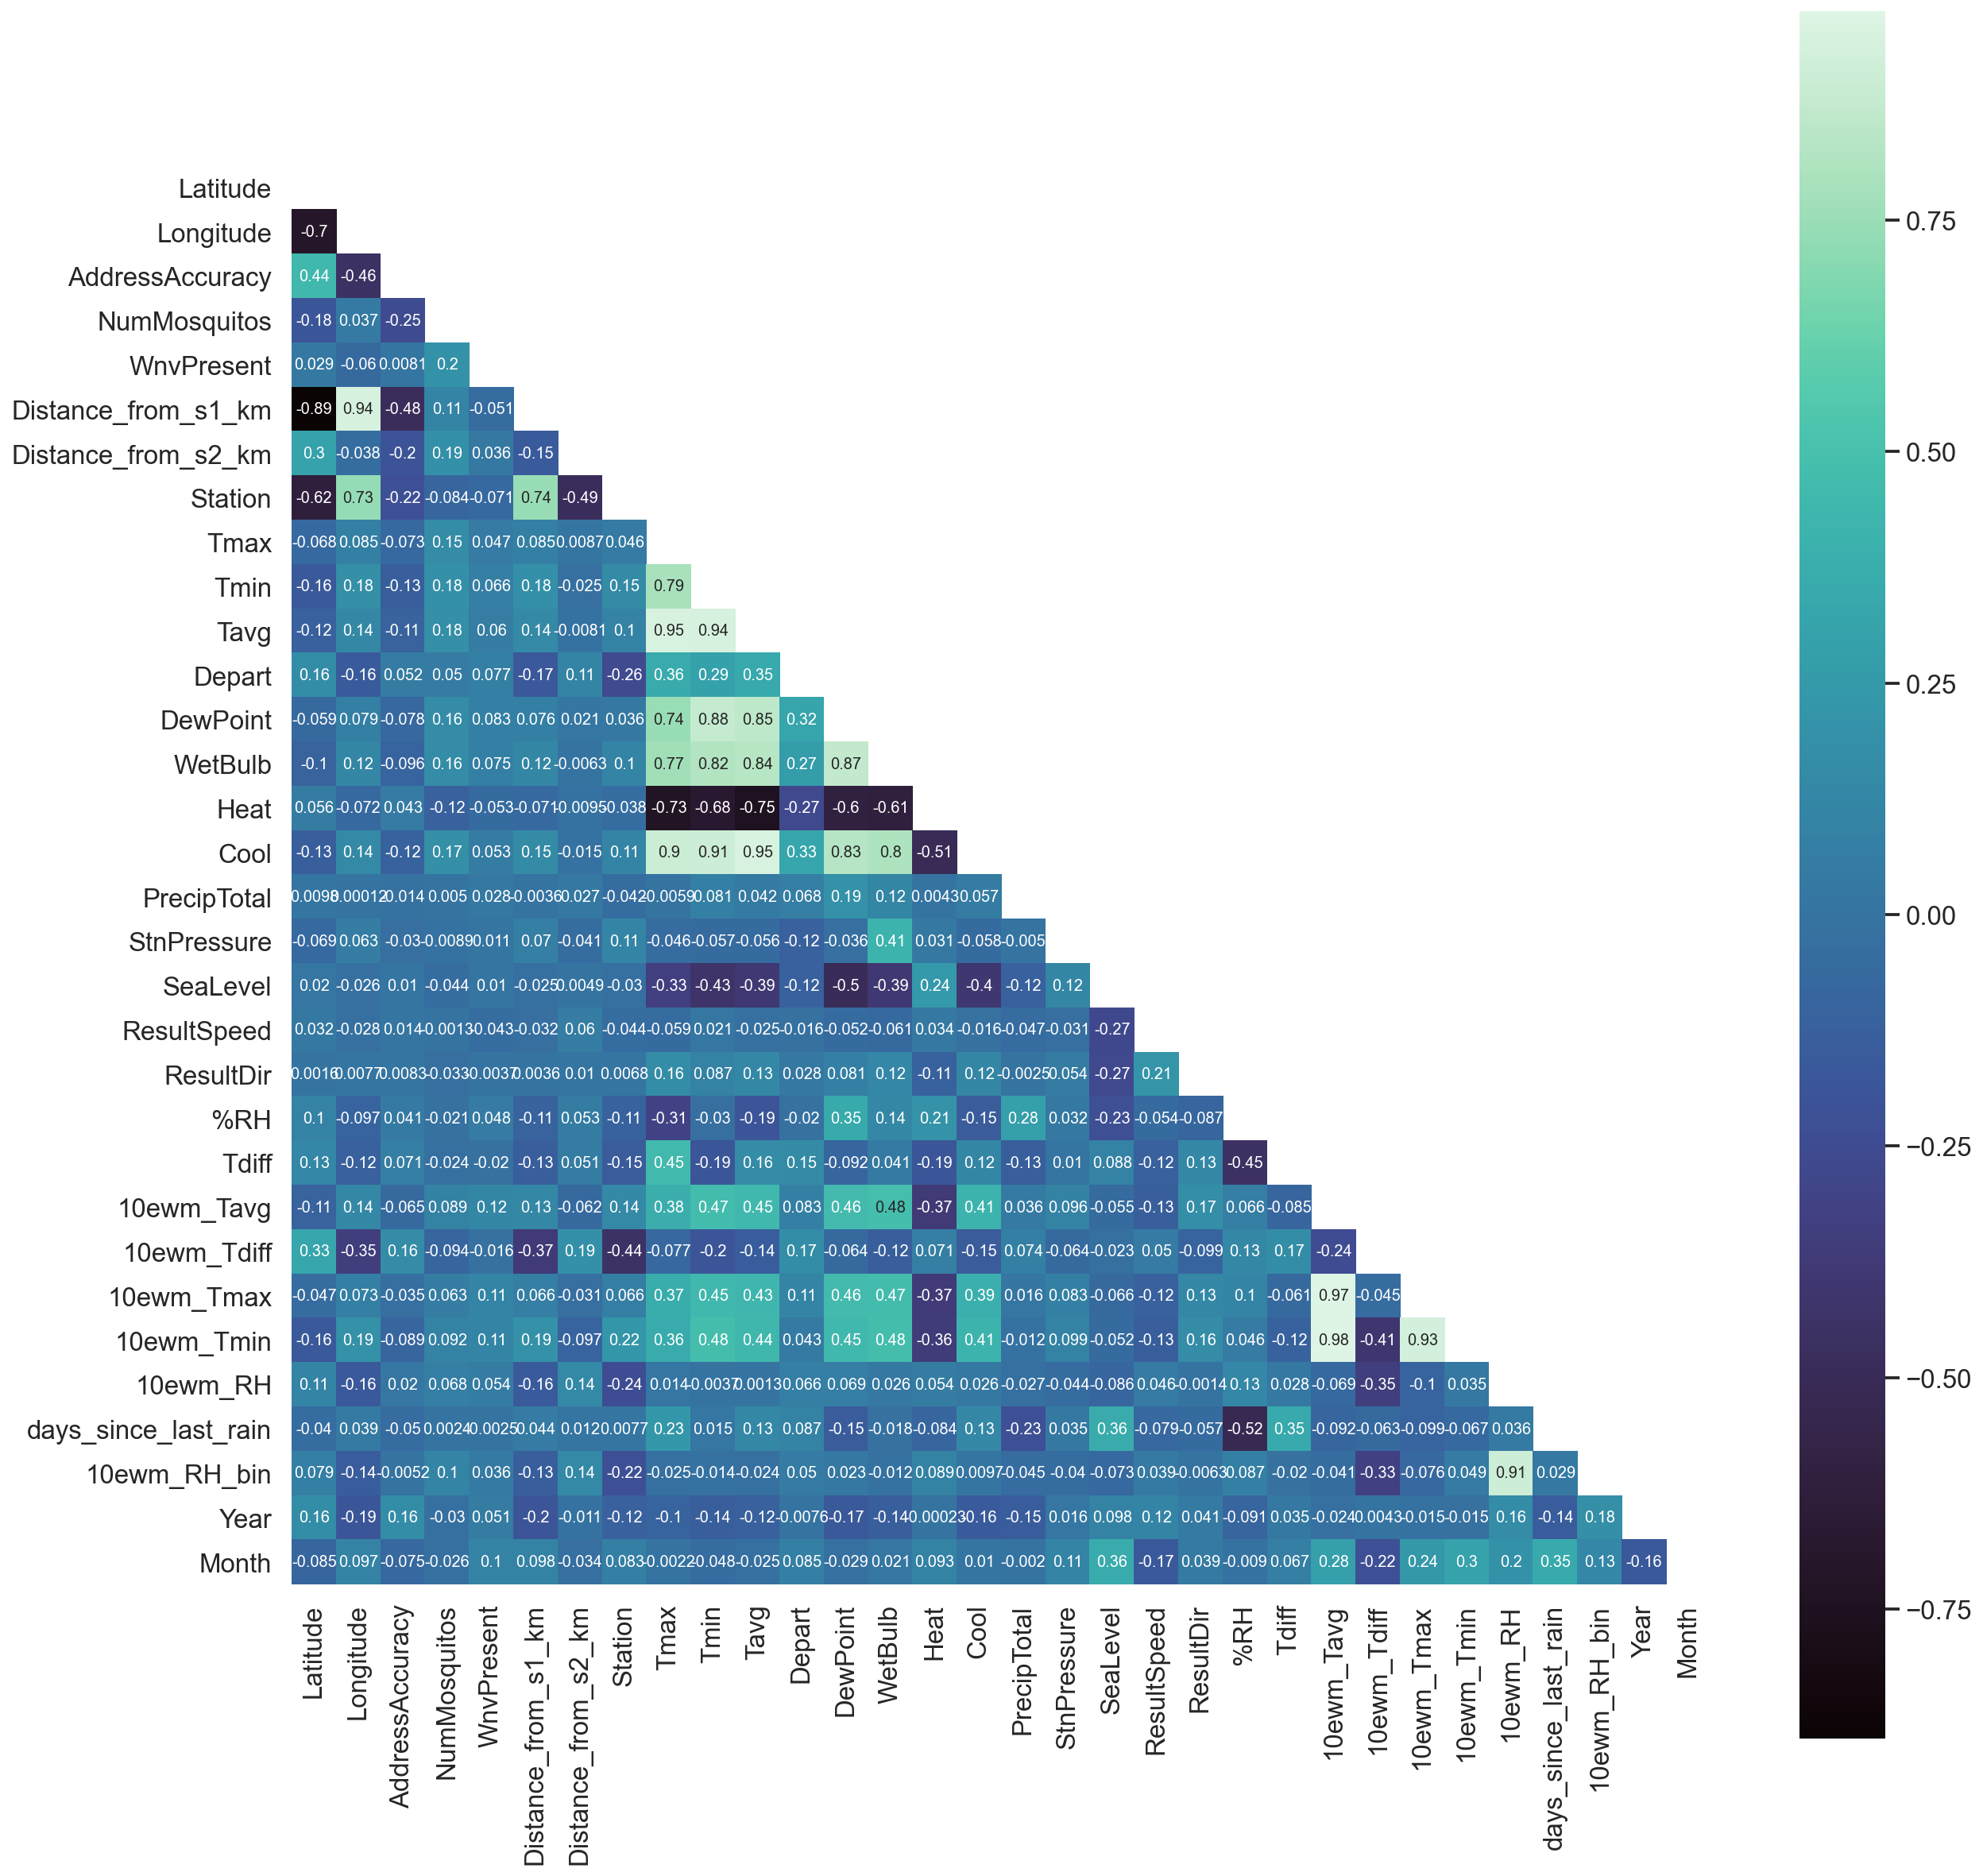

In [78]:
corr = df_merged.corr()
mask = np.zeros_like(corr)
mask[np.triu_indices_from(mask)] = True
f, ax = plt.subplots(figsize=(20, 20))
ax = sns.heatmap(corr, mask=mask, square=True, annot=True, cmap = 'mako')

Overall, there is no strongest predictor for WNvPresent. However, our 10 days lagged features tend to perform better than their original (Almost double in pearson correlation)

Text(0.5, 1.0, 'Wind Speed VS Wnv spread')

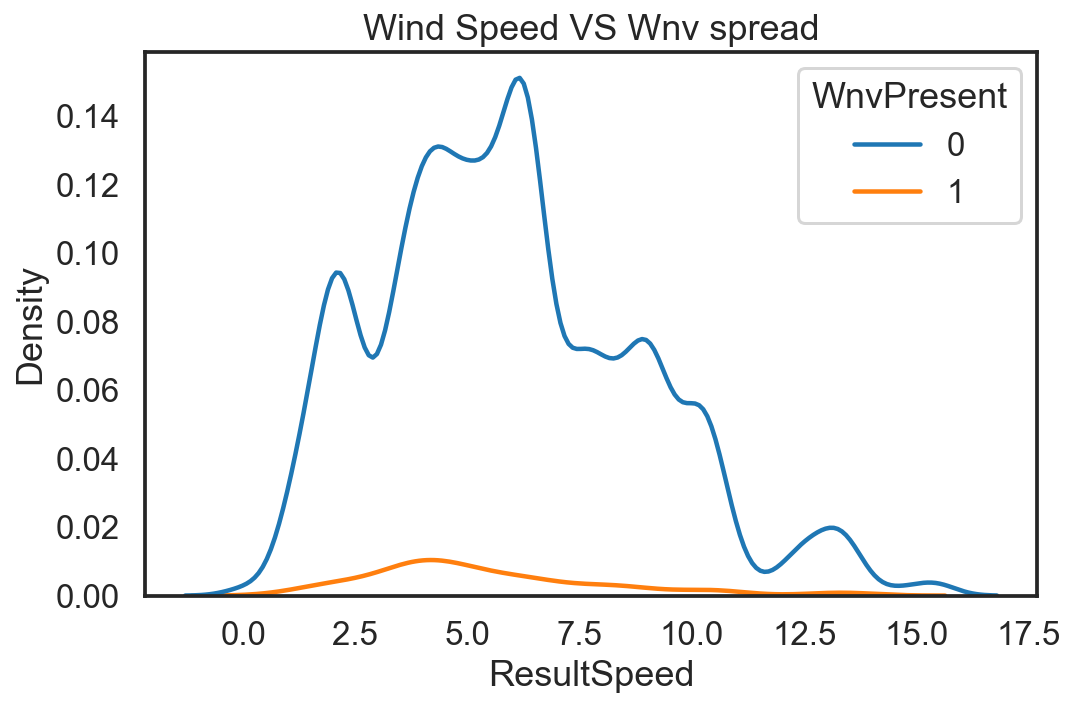

In [79]:
plt.figure(figsize=(8,5))
g = sns.kdeplot(data=df_merged, x='ResultSpeed',hue = 'WnvPresent')
g.set_title('Wind Speed VS Wnv spread')

Moderate wind (speed between 2.5 - 7.5) is most favorble condition for the WNv.

In [80]:
#List of significant weather condition 
weather_code = set()
for row in df_merged['CodeSum'].str.split():
#     print(set(row))
    weather_code = weather_code.union(set(row))

weather_code    

{'BR', 'DZ', 'FG', 'HZ', 'RA', 'TS', 'TSRA', 'VCTS'}

In [81]:
#Split weather code
df_merged['CodeSum'] = df_merged['CodeSum'].str.split()

#Manuall One Hot Encoding
df_merged['metar_BR'] = df_merged['CodeSum'].map(lambda x: 1 if 'BR' in x else 0)
df_merged['metar_DZ'] = df_merged['CodeSum'].map(lambda x: 1 if 'DZ' in x else 0)
df_merged['metar_FG'] = df_merged['CodeSum'].map(lambda x: 1 if 'FG' in x else 0)
df_merged['metar_HZ'] = df_merged['CodeSum'].map(lambda x: 1 if 'HZ' in x else 0)
df_merged['metar_RA'] = df_merged['CodeSum'].map(lambda x: 1 if 'RA' in x else 0)
df_merged['metar_TS'] = df_merged['CodeSum'].map(lambda x: 1 if 'TS' in x else 0)
df_merged['metar_TSRA'] = df_merged['CodeSum'].map(lambda x: 1 if 'TSRA' in x else 0)

Text(0.5, 1.05, 'Effect of significant weather condition on the spread of WNv')

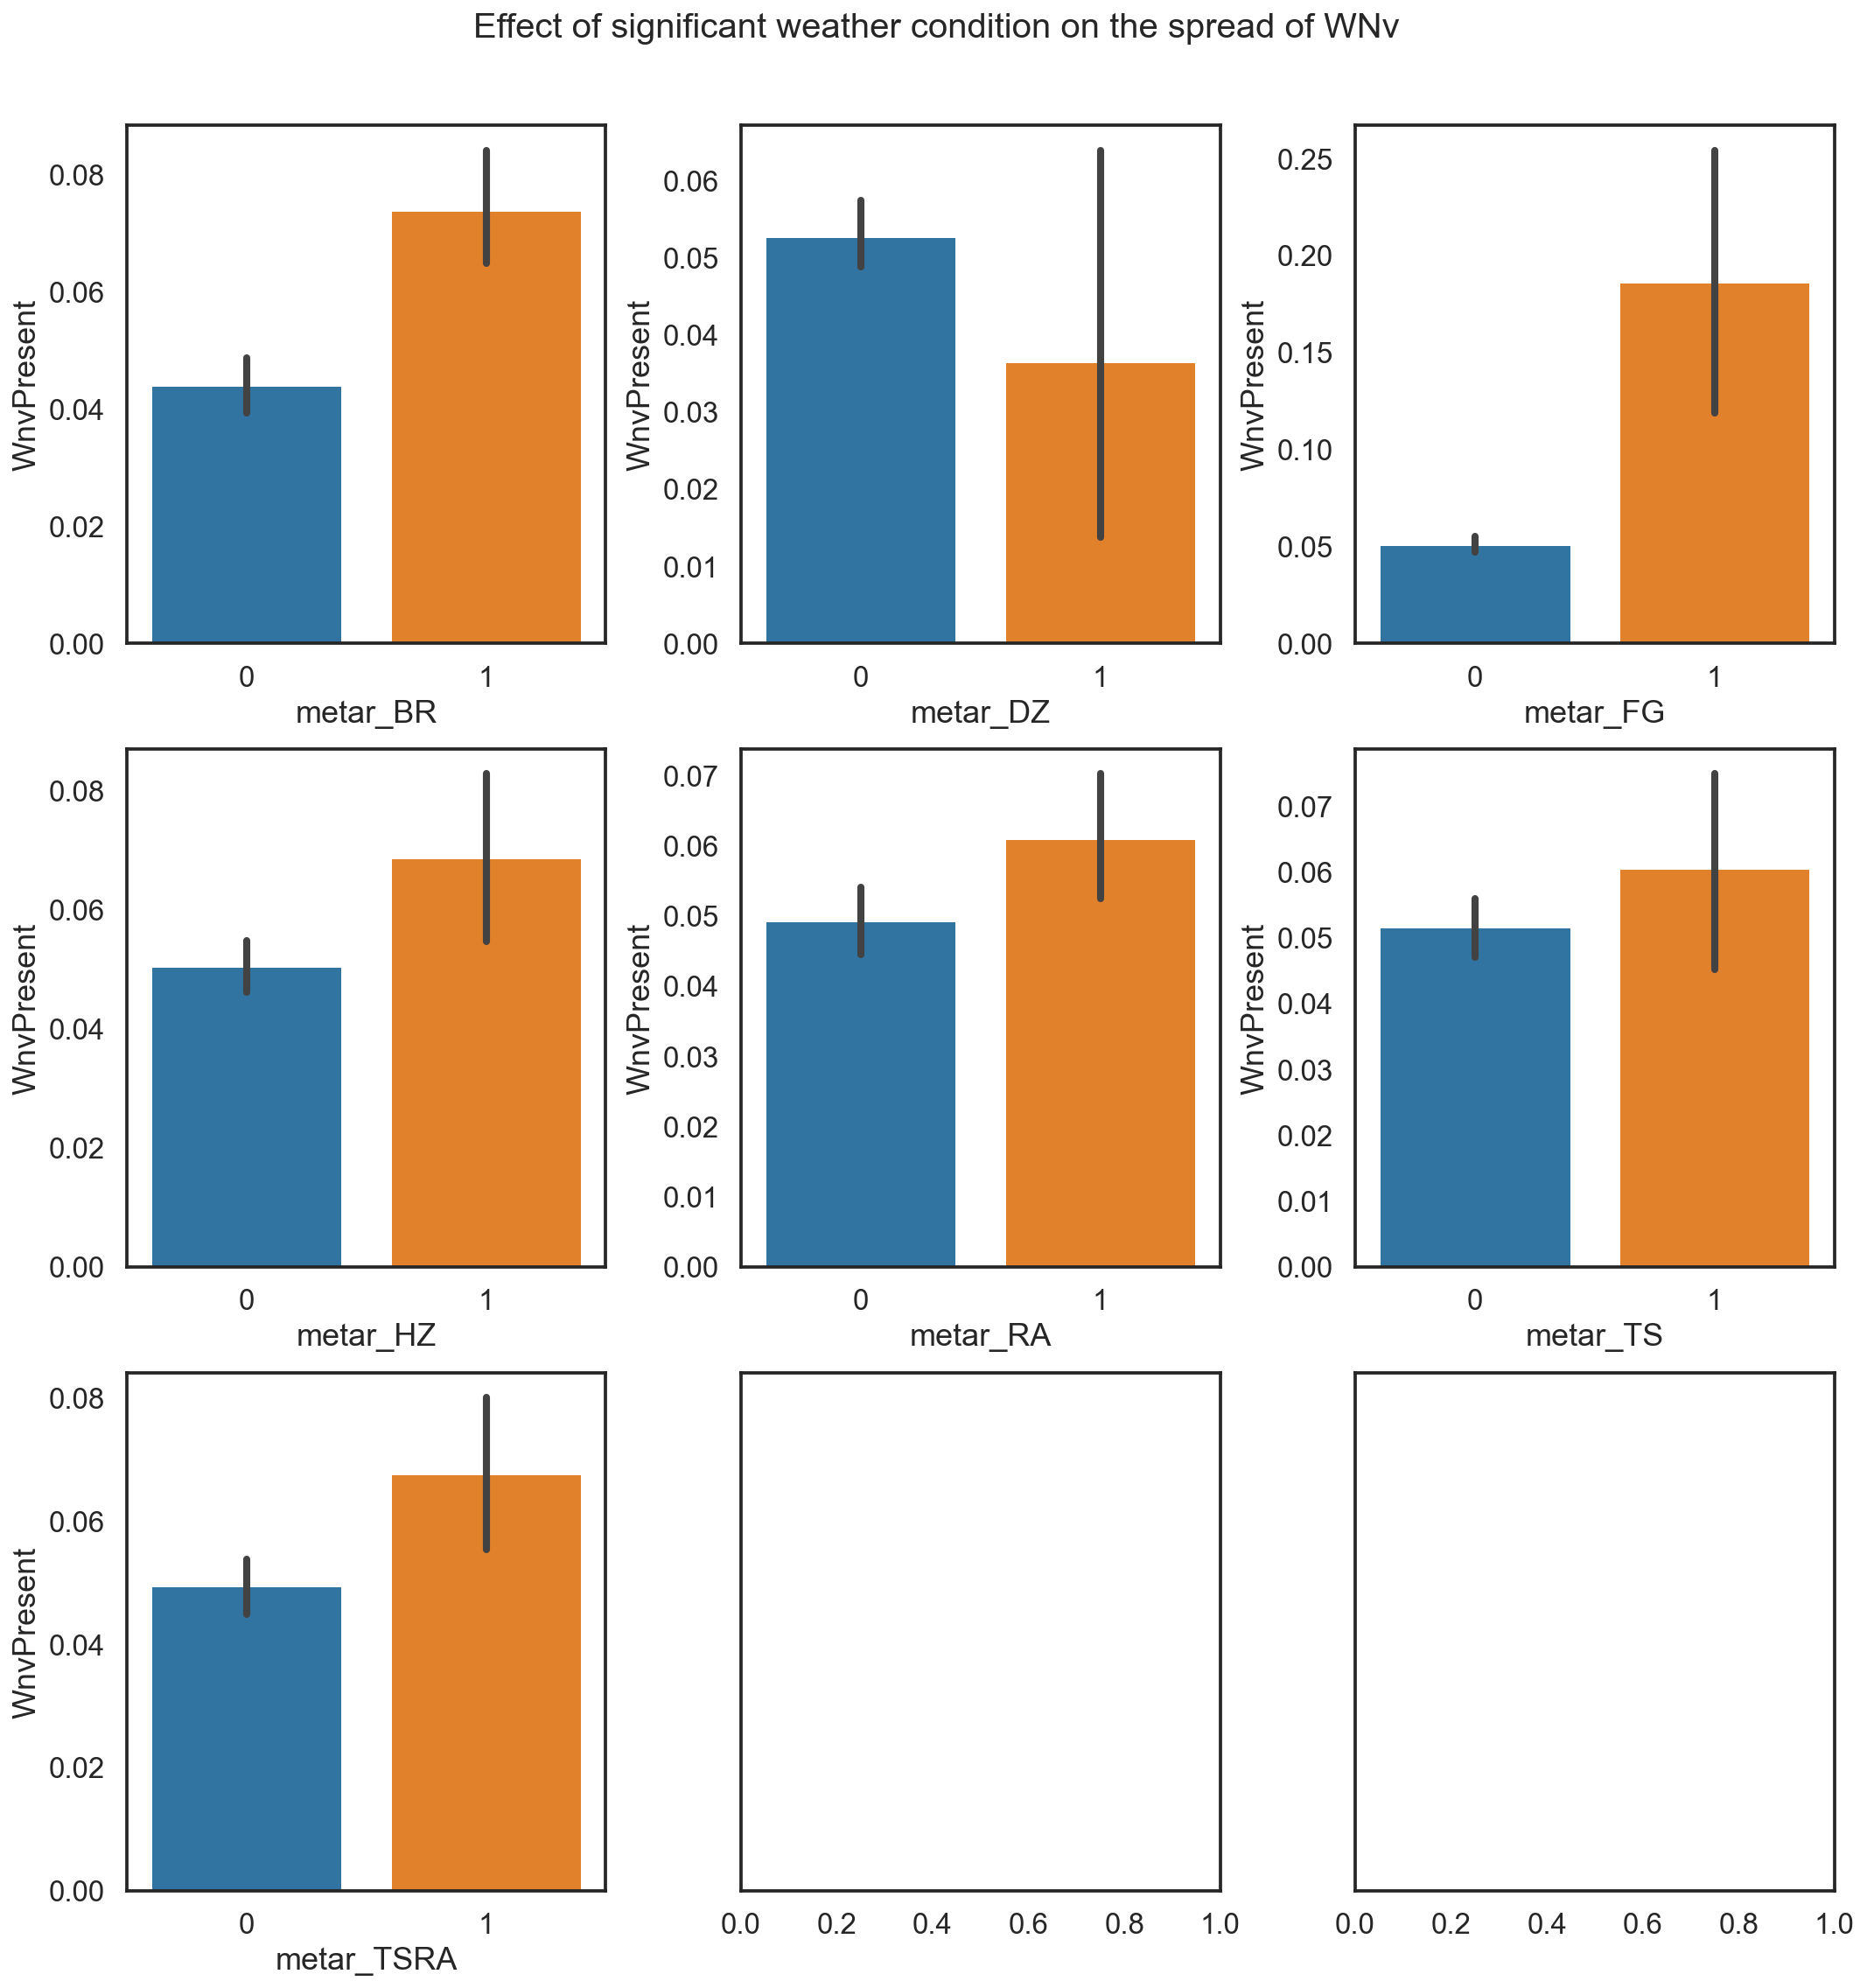

In [82]:
plt.subplots(3,3,figsize=(15,15),sharey=True)
for i,col in enumerate(df_merged.columns[df_merged.columns.str.contains('metar')],1):
    plt.subplot(3,3,i)
    g = sns.barplot(data=df_merged,x=col,y='WnvPresent')

plt.tight_layout()
plt.suptitle('Effect of significant weather condition on the spread of WNv', y = 1.05, fontsize=20)

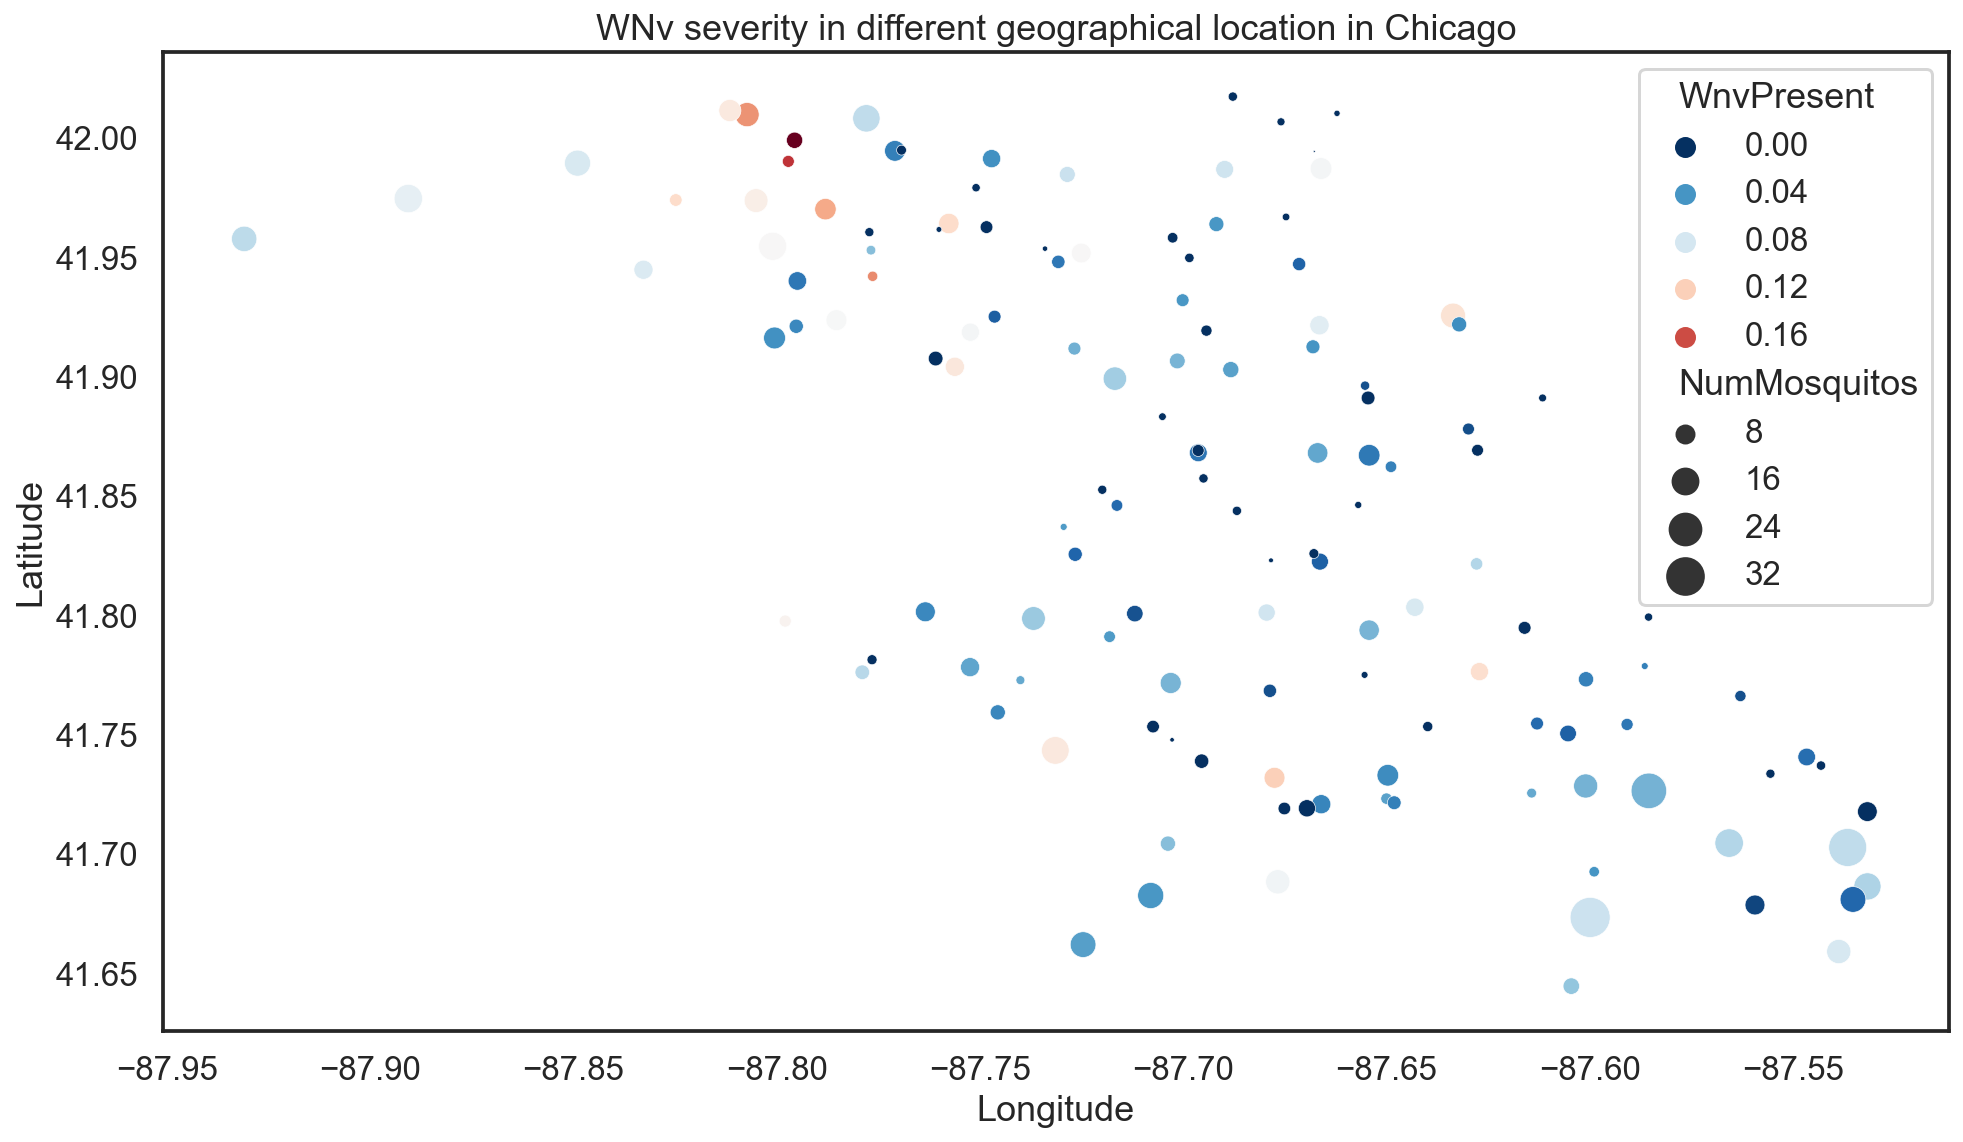

In [83]:
#Geographical distribution of the virus
plt.figure(figsize=(16,9))
g = sns.scatterplot(data=df_merged.groupby('Trap').mean().sort_values(by='WnvPresent', ascending=False), y="Latitude", x="Longitude",
                    hue='WnvPresent', size = 'NumMosquitos' ,palette='RdBu_r', sizes = (1,400))

g.set_title('WNv severity in different geographical location in Chicago');

The Northwestern part of Chicago is the location where WNv is most widely spread.

## Data Cleaning Function

In [84]:
def cleaning(data, weather, how='train', distance='empirical'):
    """
    input following information:
    data = the training / testing dataframe
    weather = weather dataframe
    spray = spraying dataframe
    how = specify whether the function will be used for {'train','test'}
    distance = specify distance calculation function {'empirical','detail'}

    """
    # Convert date into datetime object
    data['Date'] = pd.to_datetime(data['Date'])

    # Preprocessing Weather Data (Type conversion)
    weather['Date'] = pd.to_datetime(weather['Date'])
    weather['PrecipTotal'] = weather['PrecipTotal'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['WetBulb'] = weather['WetBulb'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['Heat'] = weather['Heat'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['Cool'] = weather['Cool'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['StnPressure'] = weather['StnPressure'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['SeaLevel'] = weather['SeaLevel'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['Tavg'] = weather['Tavg'].map(
        lambda s: -1 if s.strip().isalpha() else float(s))
    weather['Depart'] = weather['Depart'].map(
        lambda s: 0 if s.strip().isalpha() else float(s))

    # Feature engineering
    weather['%RH'] = 100 - (25/9)*(weather['Tavg'] - weather['DewPoint'])
    weather['Tdiff'] = weather['Tmax'] - weather['Tmin']

    # Separately clean each weather station
    weather_1 = weather[weather['Station'] == 1].set_index('Date')
    weather_2 = weather[weather['Station'] == 2].set_index('Date')

    for weat in [weather_1, weather_2]:
        # Calculating number of days since last rain
        days_since_last_rain = []
        count = 0
        for rain in weat['PrecipTotal']:
            if rain <= 0:
                count += 1
                days_since_last_rain.append(count)
            if rain > 0:
                count = 0
                days_since_last_rain.append(count)

        days_since_last_rain = pd.Series(
            days_since_last_rain, index=weat.index, name='days_since_last_rain')

        # 10 days shifting + exponential weighted mean
        d10ewm_Tavg = weat.Tavg.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_Tavg')
        d10ewm_Tdiff = weat.Tdiff.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_Tdiff')
        d10ewm_Tmax = weat.Tmax.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_Tmax')
        d10ewm_Tmin = weat.Tmin.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_Tmin')
        d10ewm_DewPoint = weat.DewPoint.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_DewPoint')
        d10ewm_WetBulb = weat.WetBulb.shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_WetBulb')
        d10ewm_RH = weat['%RH'].shift(10).resample(
            'D').mean().ewm(span=10).mean().rename('10ewm_RH')
        
        # Add additional features do the weather information
        weat = pd.concat([weat, d10ewm_Tavg, d10ewm_Tdiff, d10ewm_Tmax,
                          d10ewm_Tmin, d10ewm_DewPoint, d10ewm_WetBulb, d10ewm_RH, days_since_last_rain], axis=1)
        weat = weat.dropna(subset=['Station'])
        weat['10ewm_Tavg'] = weat['10ewm_Tavg'].fillna(weat['Tavg'])
        weat['10ewm_Tdiff'] = weat['10ewm_Tdiff'].fillna(weat['Tdiff'])
        weat['10ewm_Tmax'] = weat['10ewm_Tmax'].fillna(weat['Tmax'])
        weat['10ewm_Tmin'] = weat['10ewm_Tmin'].fillna(weat['Tmin'])
        weat['10ewm_DewPoint'] = weat['10ewm_DewPoint'].fillna(weat['DewPoint'])
        weat['10ewm_WetBulb'] = weat['10ewm_WetBulb'].fillna(weat['WetBulb'])
        weat['10ewm_RH'] = weat['10ewm_RH'].fillna(weat['%RH'])
        #Binning 10erw_rh
        def bin_rh(row):
            if row < 50:
                return 1
            elif row < 60:
                return 2
            elif row < 70:
                return 3
            else:
                return 4
        
        weat['10ewm_RH_bin'] = weat['10ewm_RH'].map(bin_rh)
        
        def bin_ws(row):
            if row < 2.5:
                return 1
            elif row < 5:
                return 2
            elif row < 7.5:
                return 3
            elif row < 10:
                return 4
            else:
                return 5
        weat['WindSpeed_bin'] = weat['ResultSpeed'].map(bin_ws)
        
        if weat.Station.unique() == 1:
            weather_1 = weat
        else:
            weather_2 = weat
    
    # Remerge weather data into a single dataframe

    weather = pd.concat([weather_1,weather_2])

    data = data.drop(columns=['Address', 'Block',
                              'Street', 'AddressNumberAndStreet'])
    
    # Select distance calculation function

    if distance == 'empirical':

        # Distance calculation 1° = 111 km  (or 60 nautical miles)
        lat_s1 = 41.995
        long_s1 = -87.933
        lat_s2 = 41.786
        long_s2 = -87.752

        data['Distance_from_s1_km'] = np.sqrt(np.power(60*(data['Latitude'] - lat_s1), 2) +
                                              np.power(60*(data['Longitude'] - long_s1), 2)) * 111/60  # *111/60 to convert from NM to km

        data['Distance_from_s2_km'] = np.sqrt(np.power(60*(data['Latitude'] - lat_s2), 2) +
                                              np.power(60*(data['Longitude'] - long_s2), 2)) * 111/60  # *111/60 to convert from NM to km

        # Select dominant weather station
        data['Station'] = data.apply(lambda row: 2 if (
            row['Distance_from_s1_km'] > row['Distance_from_s2_km']) else 1, axis=1)

        print(data['Station'].value_counts())

    elif distance == 'detail':
        from math import radians, sin, cos, atan2, sqrt
        stn1_location = (41.995, -87.933)
        stn2_location = (41.786, -87.752)

        def calc_dist_chk(lat1, lon1, lat2, lon2):
            R = 6373.0     # approximate radius of earth in km
            lat1 = radians(lat1)
            lon1 = radians(lon1)
            lat2 = radians(lat2)
            lon2 = radians(lon2)
            dlon = lon2 - lon1
            dlat = lat2 - lat1
            # formula calc distance between two points
            # haversine formula
            a = sin(dlat / 2)**2 + cos(lat1) * cos(lat2) * sin(dlon / 2)**2
            c = 2 * atan2(sqrt(a), sqrt(1 - a))
            #distance in km
            distance = R * c
            return round(distance, 4)

        def find_nearest_stn(latitude, longitude):
            dist_from_stn1 = calc_dist_chk(
                latitude, longitude, stn1_location[0], stn1_location[1])
            dist_from_stn2 = calc_dist_chk(
                latitude, longitude, stn2_location[0], stn2_location[1])
            if dist_from_stn1 <= dist_from_stn2:
                return 1
            else:
                return 2

        data['Station'] = 0
        for index, row in data.iterrows():
            nearest_station = find_nearest_stn(
                row['Latitude'], row['Longitude'])
            data.loc[index, 'Station'] = nearest_station

        print(data['Station'].value_counts())

    # Merge data and weather dataframe together
    df_merged = pd.merge(data, weather, left_on=[
                         'Date', 'Station'], right_on=['Date', 'Station'])


#   "-----------------------------------------------------------------------------------------------------"

    # Feature Engineering
    df_merged['Month'] = df_merged['Date'].dt.month
    df_merged['Month'] = df_merged['Month'].astype(object)
#     df_merged['DaysOfYear'] = df_merged['Date'].dt.dayofyear
    df_merged['WeeksOfYear'] = df_merged['Date'].dt.weekofyear
#     df_merged['Year'] = df_merged['Date'].dt.year

    # Split weather code
    df_merged['CodeSum'] = df_merged['CodeSum'].str.split()

    # Manual One Hot Encoding
    df_merged['metar_BR'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'BR' in x else 0)
    df_merged['metar_DZ'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'DZ' in x else 0)
    df_merged['metar_FG'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'FG' in x else 0)
    df_merged['metar_HZ'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'HZ' in x else 0)
    df_merged['metar_RA'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'RA' in x else 0)
    df_merged['metar_TS'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'TS' in x else 0)
    df_merged['metar_TSRA'] = df_merged['CodeSum'].map(
        lambda x: 1 if 'TSRA' in x else 0)


    # Subset features
#     all_col = ['Date', 'Species', 'Trap', 'Latitude', 'Longitude', 'AddressAccuracy',
#        'NumMosquitos', 'WnvPresent', 'Distance_from_s1_km',
#        'Distance_from_s2_km', 'Station', 'Tmax', 'Tmin', 'Tavg', 'Depart',
#        'DewPoint', 'WetBulb', 'Heat', 'Cool', 'Sunrise', 'Sunset', 'CodeSum',
#        'Depth', 'Water1', 'SnowFall', 'PrecipTotal', 'StnPressure', 'SeaLevel',
#        'ResultSpeed', 'ResultDir', 'AvgSpeed', '%RH', 'Tdiff', '10ewm_Tavg',
#        '10ewm_Tdiff', '10ewm_Tmax', '10ewm_Tmin', '10ewm_RH',
#        'days_since_last_rain', '10ewm_RH_bin', 'Year', 'Month']


    use_col = [
        'WnvPresent',
                'Month','Trap',
        # Selected Features
        'WeeksOfYear', 'Species', 'Latitude', 'Longitude', 'Tavg', 'Tdiff','Tmax', 'Tmin','DewPoint', 'WetBulb', 'ResultSpeed','WindSpeed_bin', '%RH',
        # lagged features
        '10ewm_Tavg','10ewm_Tdiff', '10ewm_Tmax', '10ewm_Tmin','10ewm_DewPoint','10ewm_WetBulb','days_since_last_rain', '10ewm_RH_bin',
        # Selected Features
        'metar_BR', 'metar_DZ', 'metar_FG', 'metar_HZ', 'metar_RA', 'metar_TS', 'metar_TSRA',
    ]

    #Included 'WNvPresent' in the training set
    if how == 'train':
        return df_merged[use_col]

    # if data is the test set, skip the 'WNvPresent' columns
    elif how == 'test':
        return df_merged[use_col[1:]]

# Preprocessing

In [85]:
train = pd.read_csv('assets/train.csv')
test = pd.read_csv('assets/test.csv')
weather = pd.read_csv('assets/weather.csv')

In [86]:
#Data Cleaning
df_train = cleaning(train, weather, how='train', distance = 'detail')
weather = pd.read_csv('assets/weather.csv')
df_test = cleaning(test, weather, how='test', distance = 'detail')

X = df_train.drop(columns='WnvPresent')
y = df_train['WnvPresent']
X_test = df_test

2    7208
1    3298
Name: Station, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:193: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


2    80892
1    35401
Name: Station, dtype: int64


C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:193: FutureWarning: Series.dt.weekofyear and Series.dt.week have been deprecated.  Please use Series.dt.isocalendar().week instead.


## Clustering

From the Exploratory Data Analysis section, we have found that the WNv was spread heavily in the Northwestern part of Chicago.

We then decided to divide the observation into several clusters in hope that it will help us capture the hotzone.



In [87]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

scores = []
for k in range(2, 15):
    cluster = KMeans(n_clusters=k,random_state=42)
    cluster.fit(X[['Latitude','Longitude']])
    inertia = cluster.inertia_
    sil_score = silhouette_score(X[['Latitude','Longitude']], cluster.labels_)

    scores.append([k, inertia, sil_score])
    
scores_df = pd.DataFrame(scores,columns = ['n_clusters','inertia','silhouette'])

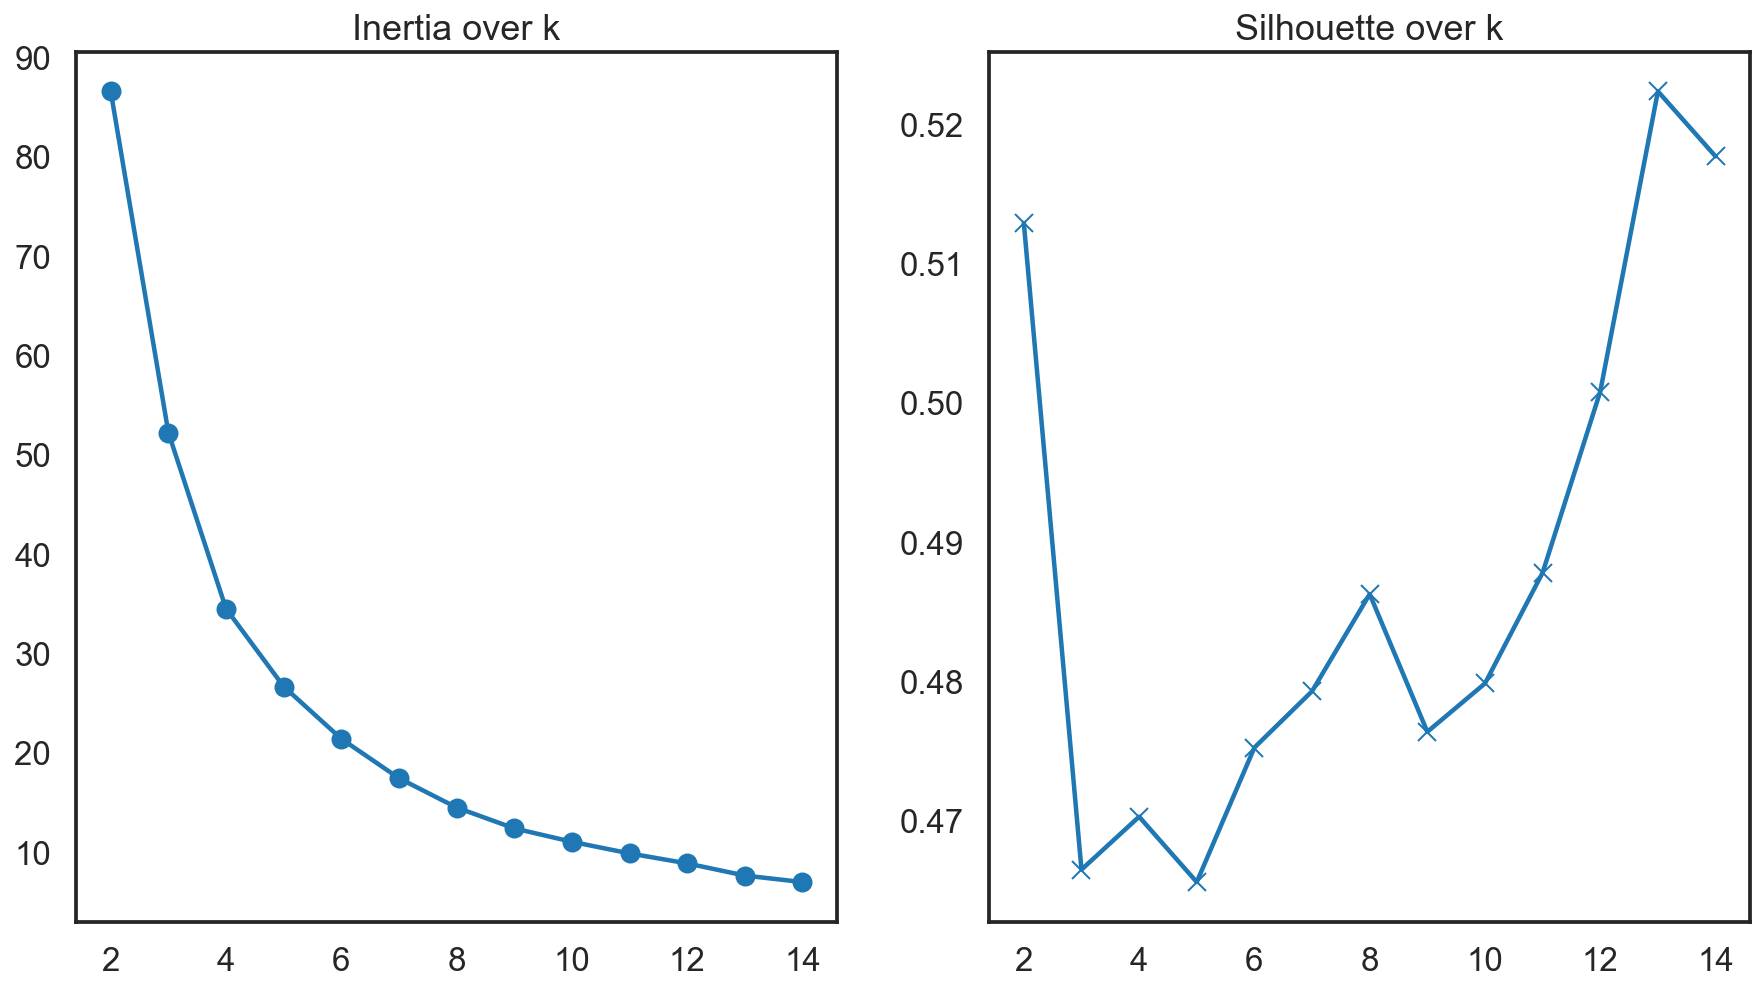

In [88]:
fig, axes = plt.subplots(1,2, figsize = (15,8))

axes[0].plot(scores_df.n_clusters,scores_df.inertia, marker = 'o')
axes[0].set_title('Inertia over k')

axes[1].plot(scores_df.n_clusters,scores_df.silhouette, marker = 'x')
axes[1].set_title('Silhouette over k');

In [89]:
cluster = KMeans(n_clusters=6,random_state=42)
cluster.fit(X[['Latitude','Longitude']])

#Clustering 
X['Cluster'] = cluster.predict(X[['Latitude','Longitude']])
X_test['Cluster'] = cluster.predict(X_test[['Latitude','Longitude']])

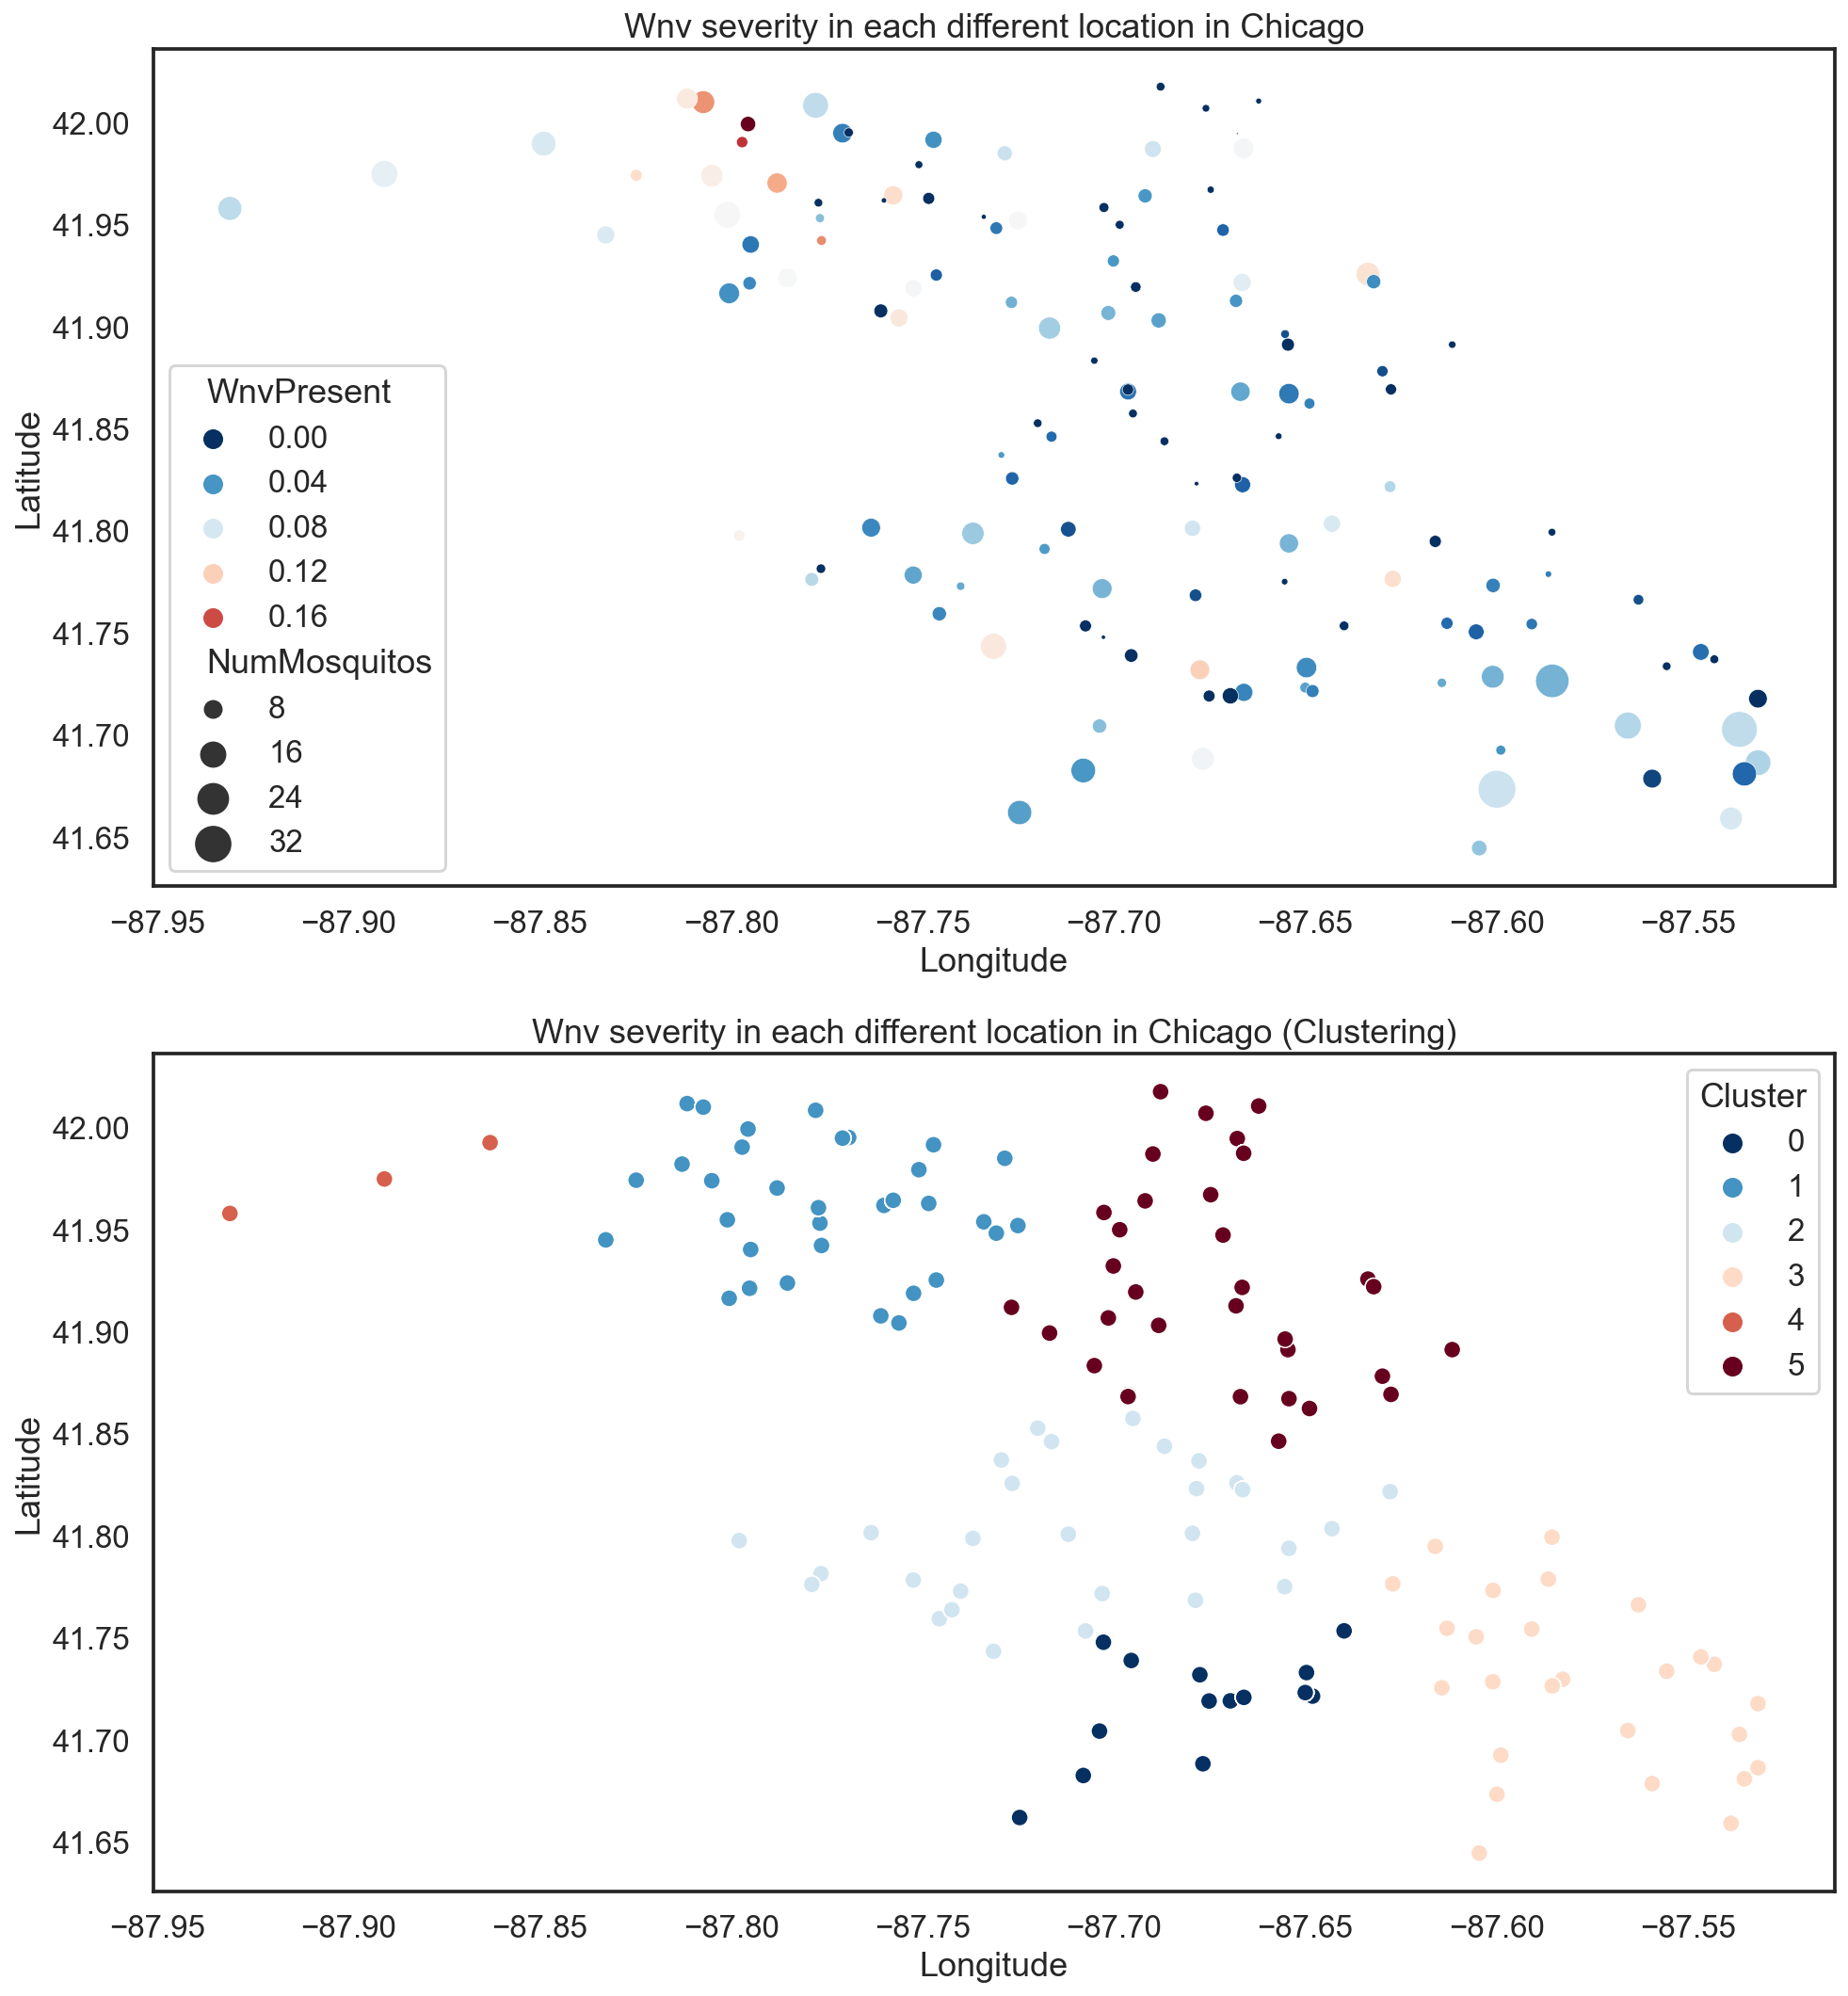

In [90]:
#Clustering vs Original data 

fig, axes = plt.subplots(2,1,figsize= (16,18))
# plt.figure(figsize=(16,9))
plt.subplot(2,1,1)
g = sns.scatterplot(data=df_merged.groupby('Trap').mean().sort_values(by='WnvPresent', ascending=False), y="Latitude", x="Longitude",
                    hue='WnvPresent', size = 'NumMosquitos' ,palette='RdBu_r', sizes = (1,400))

g.set_title('Wnv severity in each different location in Chicago');

plt.subplot(2,1,2)
g = sns.scatterplot(data=X, y="Latitude", x="Longitude",
                    hue='Cluster' ,palette='RdBu_r', )

g.set_title('Wnv severity in each different location in Chicago (Clustering)');



The result of clustering is somewhat satisfied. The Northwestern Chicago was groupped into Cluster#1. We hope this feature will has a strong predictive power.

## Train-test split

In [91]:
#We want to maintain class distribution in the training and validation set by specifiying stratify = y
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42,stratify=y)

In [92]:
y_train.value_counts(normalize=True)

0    0.947525
1    0.052475
Name: WnvPresent, dtype: float64

In [93]:
y_val.value_counts(normalize=True)

0    0.947669
1    0.052331
Name: WnvPresent, dtype: float64

## Standardize and One-hot Encoding

### Training set

In [94]:
# OneHotEncoding Species Attribute
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
ohe_columns = ['Species', 'WeeksOfYear', 'Month','Trap',
                'days_since_last_rain', 'WindSpeed_bin','10ewm_RH_bin']

enc.fit(X_train[ohe_columns])
X_train_enc = pd.DataFrame(enc.transform(X_train[ohe_columns]),
                           columns=enc.get_feature_names(X_train[ohe_columns].columns))
# Standardize
ss = StandardScaler()
ss.fit(X_train.drop(columns=ohe_columns))
X_train_sc = ss.transform(X_train.drop(columns=ohe_columns))
X_train_sc = pd.DataFrame(
    X_train_sc, columns=X_train.drop(columns=ohe_columns).columns)


# Concatanate numerical and categorical columns
X_train_prep = pd.concat([X_train_sc, X_train_enc], axis=1)

### Validation set

In [95]:
X_val_enc = pd.DataFrame(enc.transform(X_val[ohe_columns]), 
                      columns = enc.get_feature_names(X_val[ohe_columns].columns))
#Standardize
X_val_sc = ss.transform(X_val.drop(columns=ohe_columns))
X_val_sc = pd.DataFrame(X_val_sc, columns = X_val.drop(columns=ohe_columns).columns)


#Concatanate numerical and categorical columns
X_val_prep = pd.concat([X_val_sc,X_val_enc],axis = 1)

### Testing set

In [96]:
X_test_enc = pd.DataFrame(enc.transform(X_test[ohe_columns]), 
                      columns = enc.get_feature_names(X_test[ohe_columns].columns))
#Standardize
X_test_sc = ss.transform(X_test.drop(columns=ohe_columns))
X_test_sc = pd.DataFrame(X_test_sc, columns = X_test.drop(columns=ohe_columns).columns)


#Concatanate numerical and categorical columns
X_test_prep = pd.concat([X_test_sc,X_test_enc],axis = 1)
# X_test_prep = pd.concat([X_test.drop(columns=['Species','Cluster','WeeksOfYear']),X_test_enc],axis = 1)



## SMOTE to handling imbalance class problem

There are many techniques use to counteract the imbalanced class problem. In this occasion, we decided to employ the **Synthetic Minority Oversampling Technique (SMOTE)** to solve our problem.

*SMOTE works by selecting minority samples that are close in the feature space, drawing a line between the samples in the feature space and drawing a new sample at a point along that line*



In [97]:
sm = SMOTE()
Xsm_train, ysm_train = sm.fit_resample(X_train_prep,y_train)
Xsm_train = Xsm_train.sample(frac=1, random_state=42)
ysm_train = ysm_train.sample(frac=1, random_state=42)

In [98]:
print(Xsm_train.shape)
print(ysm_train.shape)
print(X_val_prep.shape)
print(y_val.shape)
print(X_test_prep.shape)

(15926, 215)
(15926,)
(2102, 215)
(2102,)
(116293, 215)


Right now, we'll have 3 different dataset for different purpose ...

1. SMOTE-Oversampling training set **(Xsm_train, ysm_train)** for model training
1. Validation set **(X_val_prep, y_val)** for model tuning
1. Testing set **(X_test_prep)** for prediction and submission

# Model Evaluation

In [99]:
### SVM 
svc = SVC(C=200,kernel = 'poly',degree = 4, random_state=1)
svc.fit(Xsm_train, ysm_train)
pred_svc = svc.predict(X_val_prep)

### Logistic Regression
lgr = LogisticRegression(C=200,random_state=42)
lgr.fit(Xsm_train, ysm_train)
pred_lgr = lgr.predict(X_val_prep)

### Decision Tree
tree = DecisionTreeClassifier(criterion="gini", max_depth=None,random_state=42)
tree.fit(Xsm_train, ysm_train)
pred_tree = tree.predict(X_val_prep)

### Random Forest
clf = RandomForestClassifier(n_estimators=300,min_samples_split=11,min_samples_leaf=7, max_features=2,max_depth= 90,random_state=1)
clf.fit(Xsm_train, ysm_train)
pred_clf = clf.predict(X_val_prep)

### XGBoost
xgb =XGBClassifier(n_estimators=300, learning_rate=0.09, max_depth=6)
xgb.fit(Xsm_train, ysm_train)
pred_xgb = xgb.predict(X_val_prep)

C:\Users\User\anaconda3\lib\site-packages\sklearn\linear_model\_logistic.py:765: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


In [100]:
svm_auc = roc_auc_score(y_val,pred_svc)
lgr_auc = roc_auc_score(y_val,pred_lgr)
tree_auc = roc_auc_score(y_val,pred_tree)
clf_auc = roc_auc_score(y_val,pred_clf)
xgb_auc = roc_auc_score(y_val,pred_xgb)

In [101]:
### Evaluate Model
print('\t\t\t\tSupport Vector Machine\n')

print(f'AUC score = {roc_auc_score(y_val,pred_svc)}')
print(f'f1 score = {f1_score(y_val,pred_svc)}')
print(f'Precision score = {precision_score(y_val,pred_svc)}')
print(f'Recall score = {recall_score(y_val,pred_svc)}')
print('')
print(classification_report(y_val,pred_svc))
print('----------------------------------------------------------')
print('')
print('')
print('\t\t\t\tLogistic Regression\n')

print(f'AUC score = {roc_auc_score(y_val,pred_lgr)}')
print(f'f1 score = {f1_score(y_val,pred_lgr)}')
print(f'Precision score = {precision_score(y_val,pred_lgr)}')
print(f'Recall score = {recall_score(y_val,pred_lgr)}')
print('')
print(classification_report(y_val,pred_lgr))
print('----------------------------------------------------------')
print('')
print('')
print('\t\t\t\tDecision Tree\n')

print(f'AUC score = {roc_auc_score(y_val,pred_tree)}')
print(f'f1 score = {f1_score(y_val,pred_tree)}')
print(f'Precision score = {precision_score(y_val,pred_tree)}')
print(f'Recall score = {recall_score(y_val,pred_tree)}')
print('')
print(classification_report(y_val,pred_tree))
print('----------------------------------------------------------')
print('')
print('')
print('\t\t\t\tRandom Forest\n')

print(f'AUC score = {roc_auc_score(y_val,pred_clf)}')
print(f'f1 score = {f1_score(y_val,pred_clf)}')
print(f'Precision score = {precision_score(y_val,pred_clf)}')
print(f'Recall score = {recall_score(y_val,pred_clf)}')
print('')
print(classification_report(y_val,pred_clf))
print('----------------------------------------------------------')
print('')
print('')
print('\t\t\t\tXGBoost\n')

print(f'AUC score = {roc_auc_score(y_val,pred_xgb)}')
print(f'f1 score = {f1_score(y_val,pred_xgb)}')
print(f'Precision score = {precision_score(y_val,pred_xgb)}')
print(f'Recall score = {recall_score(y_val,pred_xgb)}')
print('')
print(classification_report(y_val,pred_xgb))
print('----------------------------------------------------------')

				Support Vector Machine

AUC score = 0.5953952172325665
f1 score = 0.2113207547169811
Precision score = 0.18064516129032257
Recall score = 0.2545454545454545

              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1992
           1       0.18      0.25      0.21       110

    accuracy                           0.90      2102
   macro avg       0.57      0.60      0.58      2102
weighted avg       0.92      0.90      0.91      2102

----------------------------------------------------------


				Logistic Regression

AUC score = 0.6992059145673604
f1 score = 0.21406727828746178
Precision score = 0.12867647058823528
Recall score = 0.6363636363636364

              precision    recall  f1-score   support

           0       0.97      0.76      0.86      1992
           1       0.13      0.64      0.21       110

    accuracy                           0.76      2102
   macro avg       0.55      0.70      0.53      2102
weighted avg      

In [102]:
### Visualization

names = ['SVM','Logistic Regression','Decision Tree','Random Forest','XGBoost']
scores = [svm_auc,lgr_auc,tree_auc,clf_auc,xgb_auc]

df_score = pd.DataFrame({'names':names,'scores':scores}).set_index('names')

In [103]:
df_score

scores
names                        
SVM                  0.595395
Logistic Regression  0.699206
Decision Tree        0.583991
Random Forest        0.709415
XGBoost              0.579641

Text(0, 0.5, 'Score')

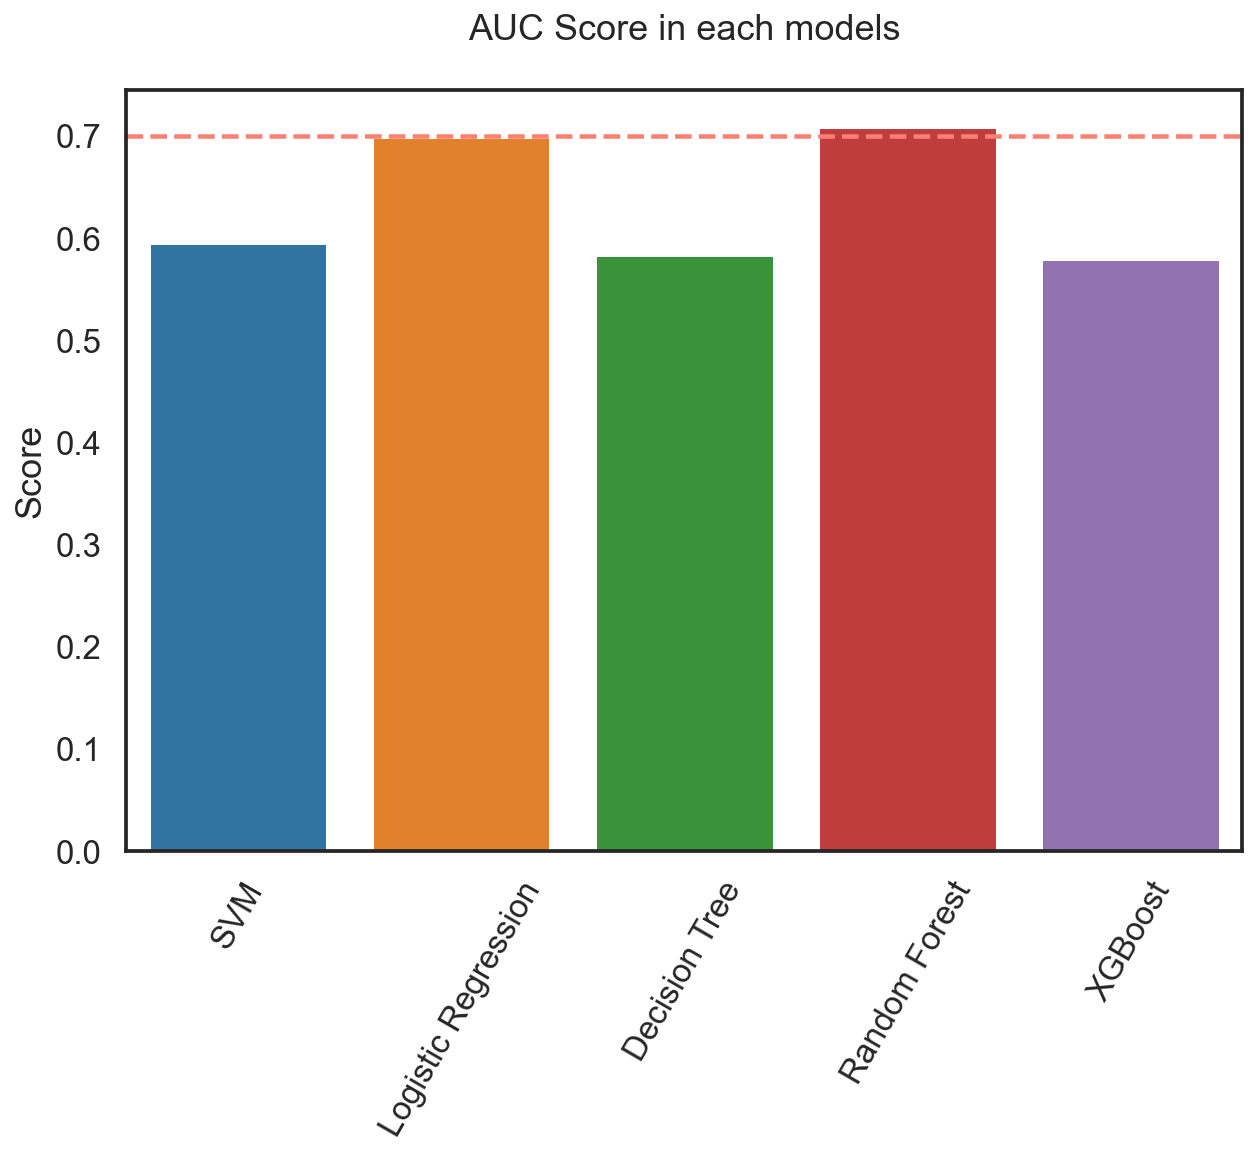

In [104]:
plt.figure(figsize=(10,7))
sns.barplot(data = df_score, x = names, y=scores)
plt.axhline(0.7,ls='--',color = 'salmon')
plt.xticks(rotation=60);
plt.title('AUC Score in each models\n')
plt.ylabel('Score')

In [105]:
def model_score(ytest,prediction):
  print(f'AUC score = {roc_auc_score(ytest,prediction)}')
  print(f'f1 score = {f1_score(ytest,prediction)}')
  print(f'Precision score = {precision_score(ytest,prediction)}')
  print(f'Recall score = {recall_score(ytest,prediction)}')
  print(classification_report(ytest,prediction))

In [106]:
### Model Random Forest
model_score(y_val, pred_clf)

AUC score = 0.7094149324571012
f1 score = 0.24100719424460432
Precision score = 0.15022421524663676
Recall score = 0.6090909090909091
              precision    recall  f1-score   support

           0       0.97      0.81      0.88      1992
           1       0.15      0.61      0.24       110

    accuracy                           0.80      2102
   macro avg       0.56      0.71      0.56      2102
weighted avg       0.93      0.80      0.85      2102



In [107]:
def confusion_eval(y_test,prediction):
  tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
  
  print('All Data:', len(y_test))
  print('Correctly Predict that Wnv is Positive (TP):',tp)
  print('Correctly Predict that Wnv is Negative (TN):',tn)
  print('Incorrectly Predict that Wnv is Positive (FP):',fp)
  print('Incorrectly Predict that Wnv is Negative (FN):',fn)

In [108]:
### Model Random Forest
confusion_eval(y_val, pred_clf)

All Data: 2102
Correctly Predict that Wnv is Positive (TP): 67
Correctly Predict that Wnv is Negative (TN): 1613
Incorrectly Predict that Wnv is Positive (FP): 379
Incorrectly Predict that Wnv is Negative (FN): 43


In [109]:
def confusion_score(y_test,prediction):
  tn, fp, fn, tp = confusion_matrix(y_test,prediction).ravel()
    
  print('Accuracy: {}'.format(round((tp+tn)/(tp+fp+tn+fn),4)))
  print('Misclassification rate: {}'.format(round((fp+fn)/(tp+fp+tn+fn),4)))
  print('Precision: {}'.format(round(tp/(tp+fp),4)))
  print('Recall: {}'.format(round(tp/(tp+fn),4)))
  print('Specificity: {}'.format(round(tn/(tn+fp),4)))

In [110]:
### Model Random Forest
confusion_score(y_val, pred_clf)

Accuracy: 0.7992
Misclassification rate: 0.2008
Precision: 0.1502
Recall: 0.6091
Specificity: 0.8097


In [111]:
def confustion_plot(model, Xtest, ytest):
  disp = plot_confusion_matrix(model, Xtest, ytest,cmap = plt.cm.viridis)
  plt.grid()
  plt.title('Evaluate Model\n')
  plt.xlabel('Prediction')
  plt.ylabel('Actual')
  print(disp)

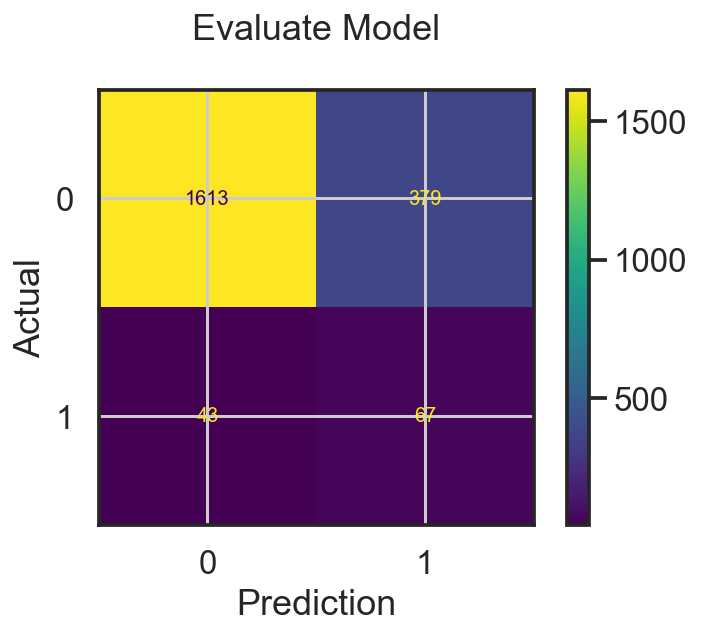

In [112]:
### Model Random Forest
confustion_plot(clf, X_val_prep, y_val)

# Full Training Data

We've splited the entire training set into training and validation set for the model evaluation process. After we've got a candidate model (RandomForestClassifier), it's better to train the model on the entire training set.

In [113]:
Xsm_train_final = pd.read_csv('assets/Xsm_train_final.csv')
ysm_train_final = pd.read_csv('assets/ysm_train_final.csv')
Xtest_final = pd.read_csv('assets/Xtest_final.csv')

In [114]:
Xsm_train_final = Xsm_train_final.drop(columns=['Unnamed: 0'])
ysm_train_final = ysm_train_final.drop(columns=['Unnamed: 0'])
Xtest_final = Xtest_final.drop(columns=['Unnamed: 0'])

In [115]:
print(Xsm_train_final.shape)
print(ysm_train_final.shape)
print(Xtest_final.shape)

(19910, 215)
(19910, 1)
(116293, 215)


In [116]:
Xsm_train_final.head()

Latitude  Longitude      Tavg     Tdiff      Tmax      Tmin  DewPoint  \
0 -0.664714   1.419745  0.108245 -0.178877  0.008605  0.133017 -0.338572   
1  0.296461  -0.076873  0.641151  0.011894  0.612073  0.660369  0.682026   
2 -1.522297   1.556466  0.907604  0.393435  0.974154  0.792207  1.319899   
3  0.964116   0.015035 -0.424661 -0.751189 -0.594864 -0.130658 -1.104020   
4 -0.999185   1.025235 -1.224020 -1.895814 -1.681106 -0.526172 -0.593722   

    WetBulb  ResultSpeed       %RH  ...  days_since_last_rain_14.0  \
0 -0.082809     0.786180 -0.833453  ...                        0.0   
1  0.563737    -0.591960  0.128297  ...                        0.0   
2  1.080975    -0.281879  0.849610  ...                        0.0   
3 -0.729356     1.096261 -1.314328  ...                        0.0   
4 -0.729356     0.889540  1.090047  ...                        0.0   

   10ewm_RH_bin_1  10ewm_RH_bin_2  10ewm_RH_bin_3  10ewm_RH_bin_4  \
0             0.0             0.0             1.0             0.0   
1             0.0             1.0             0.0             0.0   
2             0.0             0.0             1.0             0.0   
3             0.0             0.0             1.0             0.0   
4             0.0             1.0             0.0             0.0   

   WindSpeed_bin_1  WindSpeed_bin_2  WindSpeed_bin_3  WindSpeed_bin_4  \
0              0.0              0.0              0.0              1.0   
1              0.0              1.0              0.0              0.0   
2              0.0              0.0              1.0              0.0   
3              0.0              0.0              0.0              1.0   
4              0.0              0.0              0.0              1.0   

   WindSpeed_bin_5  
0              0.0  
1              0.0  
2              0.0  
3              0.0  
4              0.0  

[5 rows x 215 columns]

In [117]:
#Select all one hot encoded columns to construct Principle Components.
columns_pca = [i for i in Xsm_train_final.columns][24:]

# PCA (Principle Component Analysis)

We have total of 215 features as a result of one hot encoding features. We then decided to put all one hot encoded features into principle components that can preserved >95% explained variance.

In [118]:
### Separate features into PCA

Xsm_train_final_pca = Xsm_train_final[columns_pca]
Xtest_final_pca = Xtest_final[columns_pca]

In [119]:
from sklearn.decomposition import PCA
pca = PCA()
X_pca = pca.fit_transform(Xsm_train_final_pca)

C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
C:\Users\User\anaconda3\lib\site-packages\seaborn\_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


Text(0.5, 0, 'Number of Components')

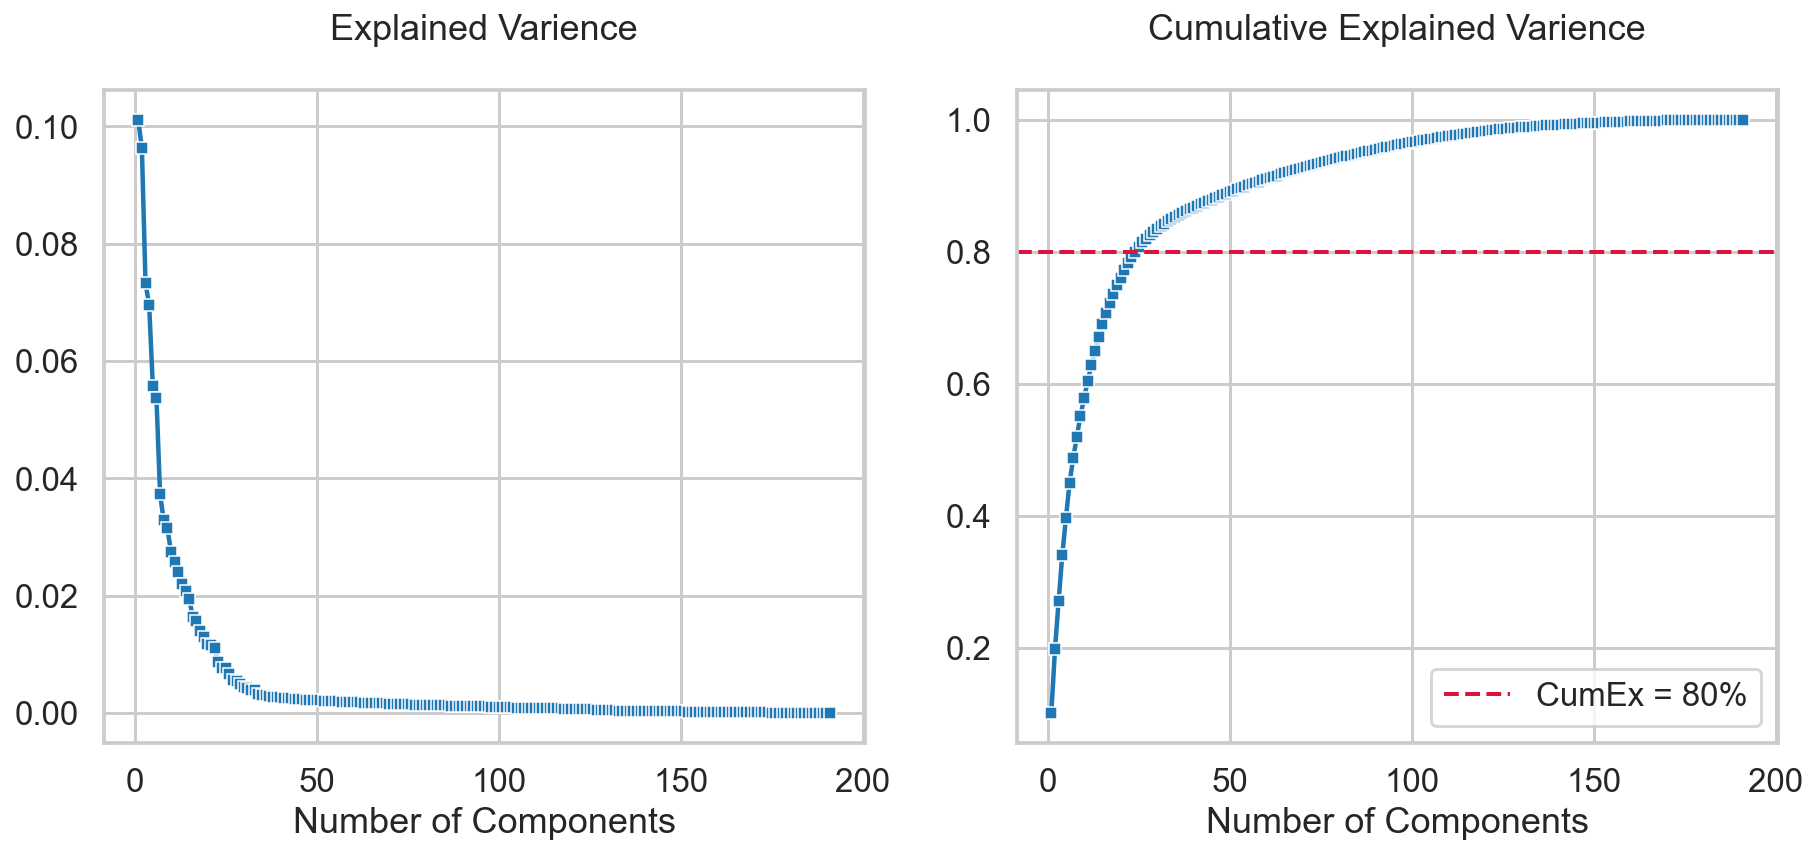

In [120]:
exp_variance = pca.explained_variance_ratio_

### Suitable number of components = 25 (Cumulative Explained Varience > 95%)

sns.set_style('whitegrid')
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15,6))
x = list(range(1, len(exp_variance)+1));
ax1 = sns.lineplot(x, exp_variance, marker = 's', markersize=6, ax=ax1);
ax2 = sns.lineplot(x, np.cumsum(exp_variance), marker = 's', markersize=6, ax=ax2);
ax2.axhline(0.80,ls='--',lw=2,c='crimson',label='CumEx = 80%')
ax2.legend()
#plt.xticks(x);
ax1.set_title('Explained Varience\n');
ax1.set_xlabel('Number of Components')
ax2.set_title('Cumulative Explained Varience\n');
ax2.set_xlabel('Number of Components')

In [121]:
df_pca = ysm_train_final.copy()
df_pca['pca1'] = X_pca[:,0]
df_pca['pca2'] = X_pca[:,1]
df_pca['pca3'] = X_pca[:,2]
df_pca['pca4'] = X_pca[:,3]

In [122]:
df_pca.head()

WnvPresent      pca1      pca2      pca3      pca4
0           0 -0.416485 -0.168248 -0.250716 -1.199904
1           1  0.855075  0.800595 -0.549964 -0.627775
2           1 -1.401043  0.473589  0.790272  0.321265
3           0  0.181444 -0.966371 -0.061557 -0.728276
4           0  0.935927 -0.324949  0.495580  0.158849

C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)
C:\Users\User\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='pca2', ylabel='Density'>

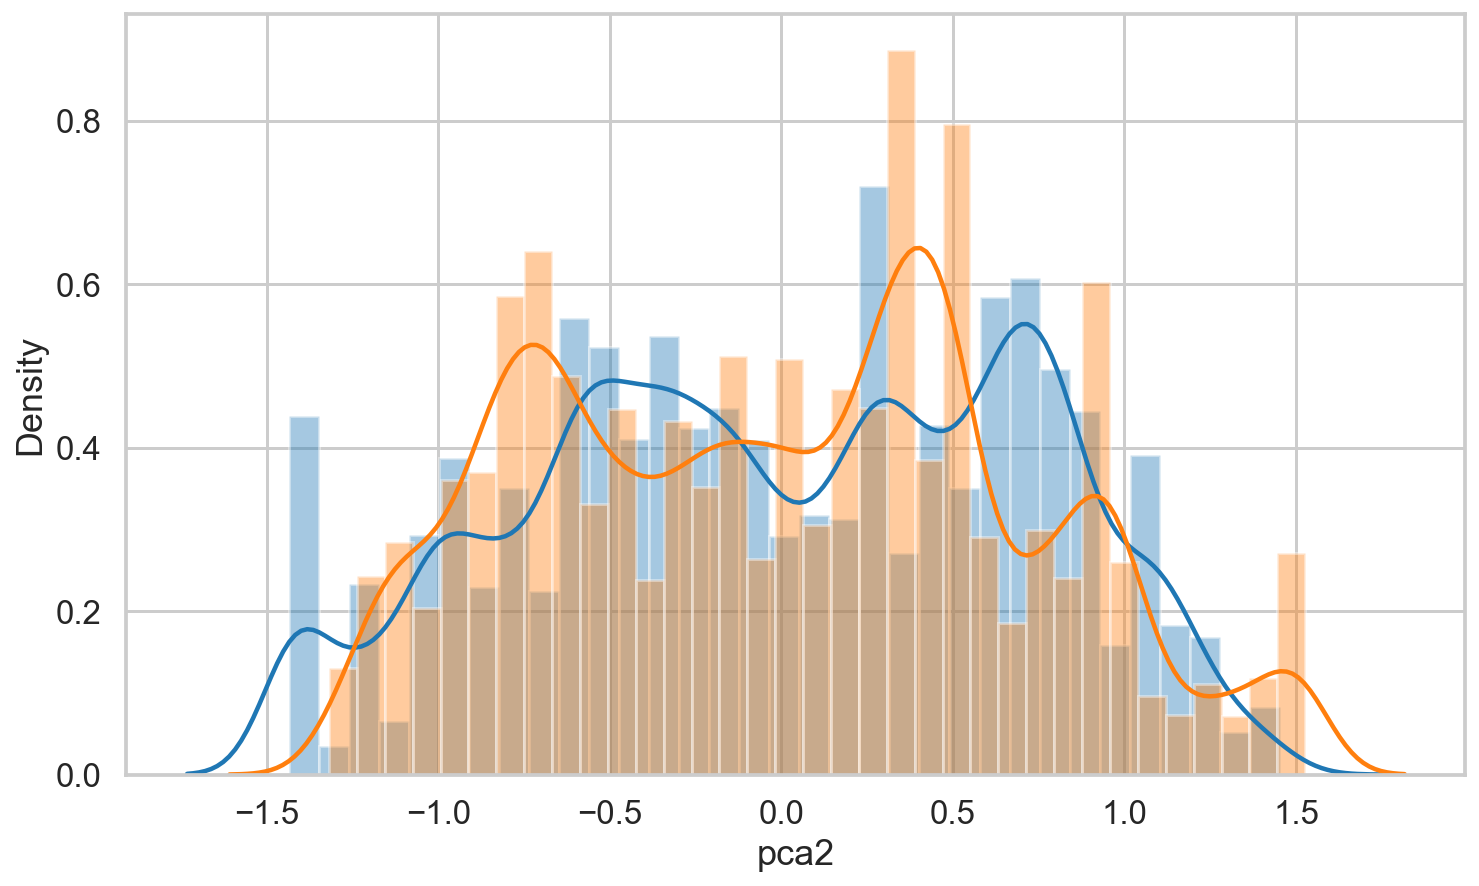

In [123]:
### Example plot only between PCA1 and PCA2

plt.figure(figsize=(12,7))
sns.distplot(df_pca['pca1'])
sns.distplot(df_pca['pca2'])

In [124]:
### From Cumulative Explained Varience >95% --> n_components = 25

pca2 = PCA(n_components=25,random_state=1)
X_pca2_train = pca2.fit_transform(Xsm_train_final_pca)
X_pca2_test = pca2.transform(Xtest_final_pca)

In [125]:
column_pca = ['pca'+str(i) for i in range(1,26)]

X_pca2_train = pd.DataFrame(X_pca2_train, columns = column_pca)
X_pca2_test = pd.DataFrame(X_pca2_test, columns = column_pca)

X_pca2_train.head()

pca1      pca2      pca3      pca4      pca5      pca6      pca7  \
0 -0.416485 -0.168248 -0.250716 -1.199904  0.542589  0.399022  0.340420   
1  0.855075  0.800596 -0.549964 -0.627775 -0.169068 -0.209741 -0.199526   
2 -1.401043  0.473589  0.790273  0.321265 -0.150399 -0.261744 -0.114256   
3  0.181444 -0.966371 -0.061557 -0.728276  0.156421  0.874666  0.408666   
4  0.935927 -0.324949  0.495580  0.158848  0.832717  0.794517  0.278015   

       pca8      pca9     pca10  ...     pca16     pca17     pca18     pca19  \
0 -0.214850 -0.188337 -0.574966  ... -0.184677 -0.659705  0.236094  0.301166   
1 -0.457182 -0.048119 -0.240550  ...  0.024232  0.120570  0.264921 -0.330745   
2  0.114761 -0.178225  0.099148  ... -0.079270 -0.110049 -0.192208  0.063741   
3  0.031371 -0.658894  0.524192  ... -0.412945 -0.018750  0.088162 -0.180601   
4 -0.559226  1.005122  0.592031  ...  0.114121 -0.305186  0.143813  0.100093   

      pca20     pca21     pca22     pca23     pca24     pca25  
0  0.232058  0.216177 -0.044739 -0.170391  0.066673 -0.015500  
1  0.029342 -0.050907 -0.227846 -0.102251 -0.044158 -0.087745  
2 -0.139857 -0.133854  0.084286 -0.064510  0.021868  0.000706  
3 -0.226478 -0.343260 -0.525108  0.266827 -0.089031  0.056267  
4  0.128162 -0.284331 -0.038086 -0.109335 -0.085024  0.152684  

[5 rows x 25 columns]

In [126]:
print(X_pca2_train.shape)
print(X_pca2_test.shape)

(19910, 25)
(116293, 25)


In [127]:
X_pca2_train = pd.concat([Xsm_train_final.drop(columns = columns_pca), X_pca2_train],axis=1)
X_pca2_test = pd.concat([Xtest_final.drop(columns = columns_pca), X_pca2_test],axis=1)

In [128]:
print(X_pca2_train.shape)
print(X_pca2_test.shape)

(19910, 49)
(116293, 49)


In [129]:
X_pca2_train.head()

Latitude  Longitude      Tavg     Tdiff      Tmax      Tmin  DewPoint  \
0 -0.664714   1.419745  0.108245 -0.178877  0.008605  0.133017 -0.338572   
1  0.296461  -0.076873  0.641151  0.011894  0.612073  0.660369  0.682026   
2 -1.522297   1.556466  0.907604  0.393435  0.974154  0.792207  1.319899   
3  0.964116   0.015035 -0.424661 -0.751189 -0.594864 -0.130658 -1.104020   
4 -0.999185   1.025235 -1.224020 -1.895814 -1.681106 -0.526172 -0.593722   

    WetBulb  ResultSpeed       %RH  ...     pca16     pca17     pca18  \
0 -0.082809     0.786180 -0.833453  ... -0.184677 -0.659705  0.236094   
1  0.563737    -0.591960  0.128297  ...  0.024232  0.120570  0.264921   
2  1.080975    -0.281879  0.849610  ... -0.079270 -0.110049 -0.192208   
3 -0.729356     1.096261 -1.314328  ... -0.412945 -0.018750  0.088162   
4 -0.729356     0.889540  1.090047  ...  0.114121 -0.305186  0.143813   

      pca19     pca20     pca21     pca22     pca23     pca24     pca25  
0  0.301166  0.232058  0.216177 -0.044739 -0.170391  0.066673 -0.015500  
1 -0.330745  0.029342 -0.050907 -0.227846 -0.102251 -0.044158 -0.087745  
2  0.063741 -0.139857 -0.133854  0.084286 -0.064510  0.021868  0.000706  
3 -0.180601 -0.226478 -0.343260 -0.525108  0.266827 -0.089031  0.056267  
4  0.100093  0.128162 -0.284331 -0.038086 -0.109335 -0.085024  0.152684  

[5 rows x 49 columns]

# GridSearch (Random Forest)
Feel free to uncomment the code block or other hyperparameters and run the code below.

Note : It will take a long time to run the following GridSearch code. (**approximately 1 hour**)

In [130]:
# #gridsearch
# clf3 = RandomForestClassifier()
# clf3_params = {
#     'n_estimators': [200,300],
#     'min_samples_split' : [9,10,11,12],
#     'max_depth': [80,90,100],
#     'min_samples_leaf': [6,7,8,9],
#     'max_features' : [2,3,4]}

# clf3_gs = GridSearchCV(clf3, param_grid=clf3_params, cv=5,scoring='roc_auc')
# clf3_gs.fit(Xsm_train_final_maybe, ysm_train_final_maybe)

In [131]:
# clf3_gs.best_params_

In [132]:
# clf3_gs.score(Xsm_train_final_maybe, ysm_train_final_maybe)

In [133]:
# pred_clf3_gs = clf3_gs.predict_proba(Xtest_train_final_maybe)

In [134]:
# pred_clf3_gs_df = pd.DataFrame(pred_clf3_gs).reset_index().rename(columns={'index':'Id',0:'NoWnv',1:'WnvPresent'})
# pred_clf3_gs_df['Id'] = [i for i in range(1,len(pred_clf3_gs)+1)]
# pred_clf3_gs_df.drop('NoWnv',axis=1,inplace=True)

In [135]:
# pred_clf3_gs_df.head()

In [136]:
# pred_clf3_gs_df.to_csv('pred_clf3_gs_2.csv',index=False)

# Random Forest (SMOTE + PCA) >> Test

The best performing model is a RandomForestClassifier. We therefore decided to finetuning it using GridSearchCV with following hyperparameters ...

- 'n_estimators' : [200,300],
- 'min_samples_split' : [9,10,11,12],
- 'max_depth' : [80,90,100],
- 'min_samples_leaf' : [6,7,8,9],
- 'max_features' : [2,3,4]}

The GridSearch process take extremely long time to run. So, we carried it out separately. The result that yield best cross validation auc_score is RandomForestClassifier with following hyperparameters
- n_estimators = 200
- min_samples_split = 11
- min_samples_leaf = 7
- max_features = 2
- max_depth = 90

In [137]:
clf3 = RandomForestClassifier(n_estimators=200,min_samples_split=11,min_samples_leaf=7, max_features=2,max_depth= 90,random_state=1)
clf3.fit(X_pca2_train, ysm_train_final)

C:\Users\User\anaconda3\lib\site-packages\ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


RandomForestClassifier(max_depth=90, max_features=2, min_samples_leaf=7,
                       min_samples_split=11, n_estimators=200, random_state=1)

In [138]:
pred_clf3 = clf3.predict_proba(X_pca2_test)
pred_clf3[:20]

array([[0.90621025, 0.09378975],
       [0.95249248, 0.04750752],
       [0.88847947, 0.11152053],
       [0.9411198 , 0.0588802 ],
       [0.93785591, 0.06214409],
       [0.9411198 , 0.0588802 ],
       [0.9411198 , 0.0588802 ],
       [0.9411198 , 0.0588802 ],
       [0.90929702, 0.09070298],
       [0.94912856, 0.05087144],
       [0.8900003 , 0.1099997 ],
       [0.9353752 , 0.0646248 ],
       [0.93803482, 0.06196518],
       [0.93803482, 0.06196518],
       [0.93803482, 0.06196518],
       [0.93803482, 0.06196518],
       [0.91645908, 0.08354092],
       [0.94915633, 0.05084367],
       [0.89801218, 0.10198782],
       [0.94657318, 0.05342682]])

In [139]:
pred_clf3 = pd.DataFrame(pred_clf3).reset_index().rename(columns={'index':'Id',0:'NoWnv',1:'WnvPresent'})
pred_clf3['Id'] = [i for i in range(1,len(pred_clf3)+1)]
pred_clf3 = pred_clf3.drop(columns=['NoWnv'])

In [140]:
pred_clf3

Id  WnvPresent
0            1    0.093790
1            2    0.047508
2            3    0.111521
3            4    0.058880
4            5    0.062144
...        ...         ...
116288  116289    0.120151
116289  116290    0.114651
116290  116291    0.121515
116291  116292    0.121515
116292  116293    0.121515

[116293 rows x 2 columns]

In [141]:
#Submission files
pred_clf3.to_csv('pred_clf3_62.csv',index=False) ### Best score clf3_46 >> pca =25 (_maybe)

# Feature Importance

In [142]:
importance = pd.DataFrame(clf3.feature_importances_,index = X_pca2_train.columns,columns = ['coef'])
importance.sort_values(by='coef',ascending=False)

coef
pca2            0.040399
10ewm_DewPoint  0.035884
pca9            0.035644
pca3            0.035293
pca1            0.032322
pca7            0.028387
10ewm_Tmin      0.028031
pca8            0.027445
10ewm_Tavg      0.027325
pca6            0.027260
pca23           0.026768
10ewm_Tmax      0.026349
10ewm_WetBulb   0.026283
pca20           0.026119
pca22           0.026101
pca21           0.025597
pca11           0.025277
pca14           0.024829
pca15           0.023773
pca16           0.023349
pca13           0.022838
pca10           0.022208
Longitude       0.022093
pca24           0.022045
Tmax            0.021469
pca12           0.021364
pca4            0.021218
pca5            0.020967
pca18           0.020670
pca17           0.020110
pca19           0.019922
ResultSpeed     0.018963
Tavg            0.018749
WetBulb         0.018583
Latitude        0.018548
Cluster         0.017620
pca25           0.017282
DewPoint        0.016020
Tmin            0.015430
10ewm_Tdiff     0.013946
%RH             0.013600
Tdiff           0.011846
metar_BR        0.003746
metar_RA        0.002884
metar_HZ        0.001689
metar_TSRA      0.001524
metar_TS        0.001024
metar_FG        0.000897
metar_DZ        0.000309

In [143]:
pc_importance = pd.concat([
           pd.Series(pca2.components_[1],name='PC2'),
           pd.Series(pca2.components_[2],name='PC3'),
           pd.Series(pca2.components_[8],name='PC9')
],axis=1,)
pc_importance.index = Xsm_train_final_pca.columns
pc_importance.head()

PC2       PC3       PC9
Species_CULEX ERRATICUS        -0.000064 -0.000182  0.000143
Species_CULEX PIPIENS           0.290801 -0.068969 -0.301256
Species_CULEX PIPIENS/RESTUANS -0.190713 -0.112936 -0.171962
Species_CULEX RESTUANS         -0.094561  0.172959  0.467106
Species_CULEX SALINARIUS       -0.002289  0.003818  0.000761

In [144]:
pc_importance.sort_values(by='PC2',ascending=False).head(20)

PC2       PC3       PC9
Month_8                   0.572276  0.005647  0.061995
WindSpeed_bin_2           0.298214 -0.461377  0.039738
Species_CULEX PIPIENS     0.290801 -0.068969 -0.301256
10ewm_RH_bin_2            0.289691  0.179555 -0.028992
WeeksOfYear_33            0.232042 -0.085909 -0.000295
WeeksOfYear_34            0.148875  0.136256  0.015544
days_since_last_rain_0.0  0.115810  0.470718  0.177356
WeeksOfYear_31            0.067425  0.014675  0.073600
days_since_last_rain_7.0  0.059617 -0.085278 -0.027886
WeeksOfYear_35            0.059121 -0.104237 -0.055267
WeeksOfYear_32            0.038765  0.054995 -0.010138
WindSpeed_bin_1           0.027748 -0.001937  0.167599
Trap_T138                 0.020683  0.023536 -0.025127
Trap_T115                 0.014329  0.003210 -0.132970
Trap_T143                 0.013109  0.003839  0.002774
Trap_T061                 0.011446 -0.002007  0.006629
Trap_T016                 0.009490  0.003206  0.001284
Trap_T128                 0.009113  0.001560 -0.013230
Trap_T006                 0.008650 -0.002308  0.001416
Trap_T235                 0.008490 -0.006350  0.000428